## Loading Data

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.metrics import confusion_matrix,classification_report,recall_score,accuracy_score,precision_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [13]:
train_df = pd.read_csv('../data/home-credit-default-risk/application_train.csv')
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We can observe that many columns have more than 20%, we need to analyse if these features are worth to keep or if it's better to drop them.

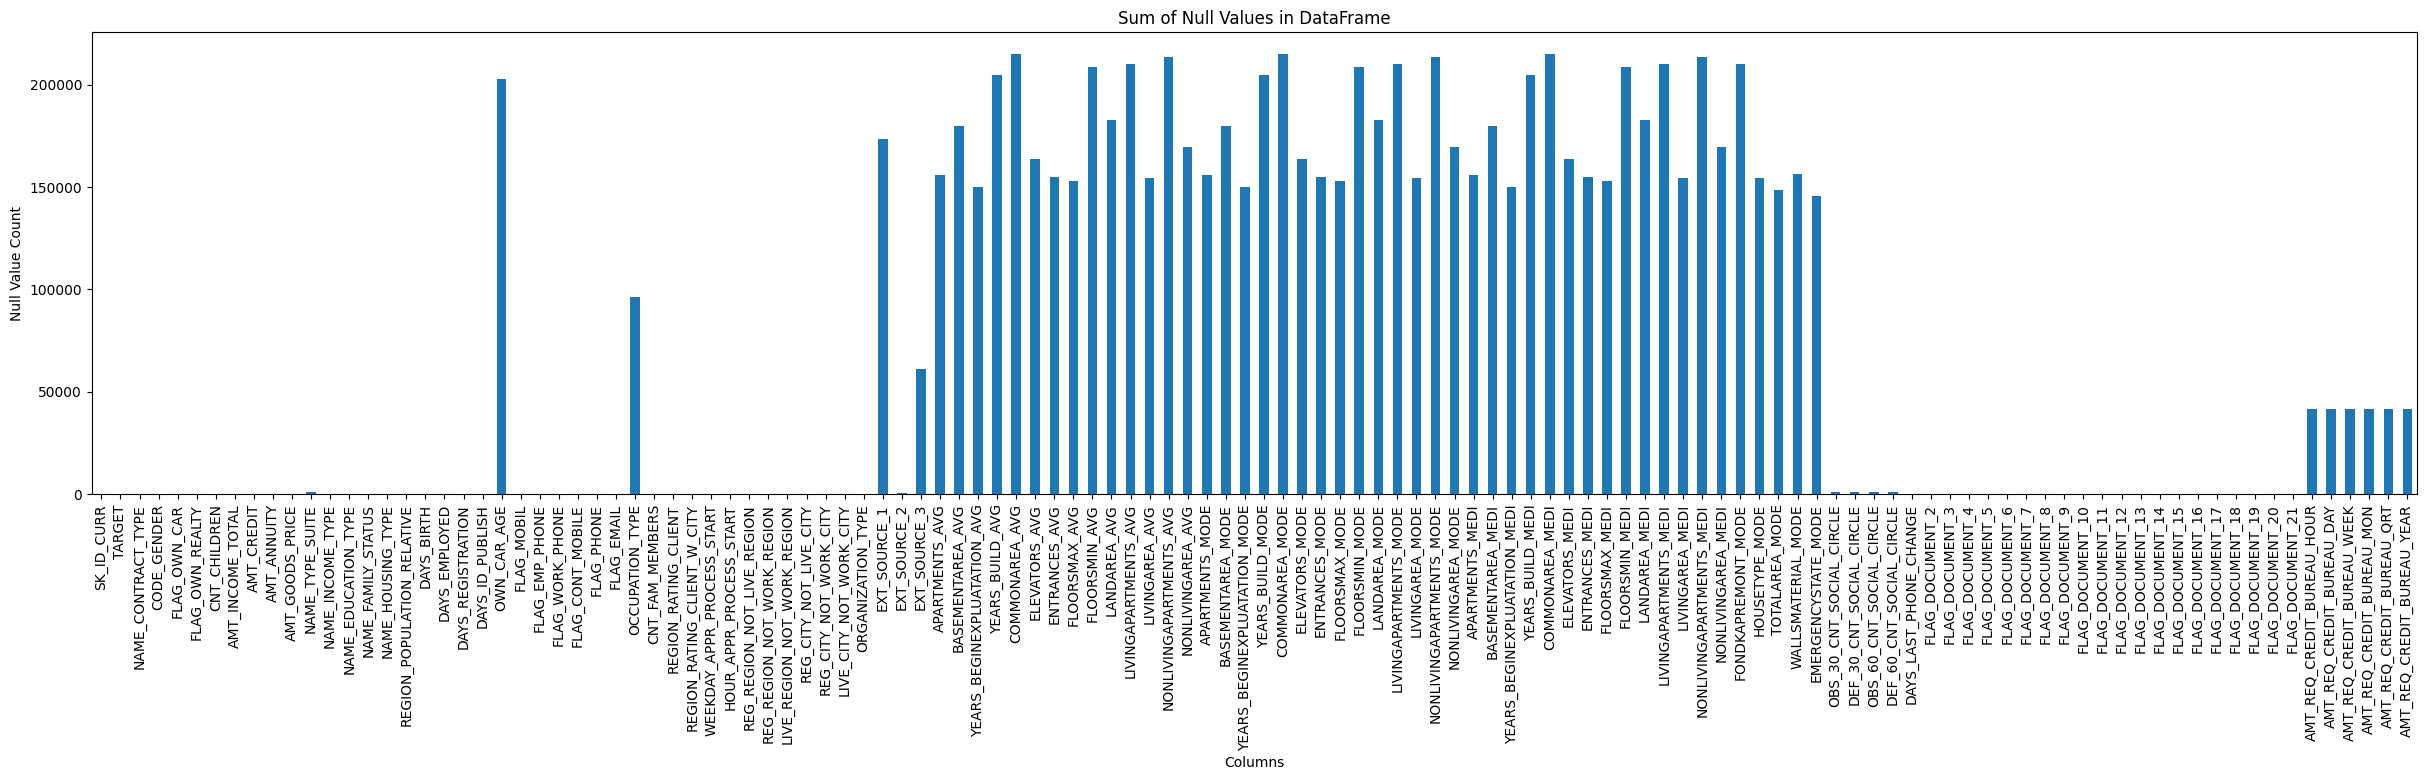

In [14]:
# Calculate the sum of null values for each column
null_sum = train_df.isnull().sum()

# Increase the figure size
plt.figure(figsize=(30, 6))

# Plot the sum of null values
null_sum.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Sum of Null Values in DataFrame')
plt.show()

Something else to consider before looking for the best features is that the classes are imbalanced

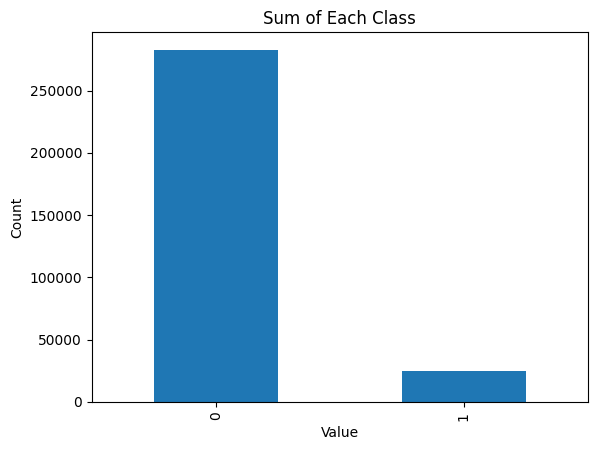

In [15]:
classes_sum = train_df['TARGET'].value_counts()

classes_sum.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Sum of Each Class')
plt.show()

In [16]:
count_class_one = train_df['TARGET'].eq(1).sum()
count_class_one

24825

We will create a new dataset that contains the same amount of classes so we can analyse the features with a correlation matrix

In [17]:
class_zero = train_df[train_df['TARGET'] == 0].sample(24825)
class_one = train_df[train_df['TARGET'] == 1].sample(24825)

balanced_df = pd.concat([class_zero, class_one])
balanced_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
189157,319303,0,Cash loans,F,N,Y,1,76500.0,918468.0,30352.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
249449,388614,0,Cash loans,F,N,N,0,225000.0,673875.0,19440.0,...,0,0,0,0,0.0,0.0,0.0,0.0,4.0,4.0
43991,150945,0,Cash loans,M,Y,Y,0,225000.0,225000.0,14377.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
152463,276713,0,Cash loans,F,N,Y,0,270000.0,902209.5,35910.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
274398,418065,0,Cash loans,F,N,Y,1,247500.0,364500.0,28926.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
correlation = balanced_df.corr()

# sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels= correlation.columns)

# cmap = sns.diverging_palette(5, 250, as_cmap=True)

# def magnify():
#     return [dict(selector="th",
#                  props=[("font-size", "7pt")]),
#             dict(selector="td",
#                  props=[('padding', "0em 0em")]),
#             dict(selector="th:hover",
#                  props=[("font-size", "12pt")]),
#             dict(selector="tr:hover td:hover",
#                  props=[('max-width', '500px'),
#                         ('font-size', '12pt')])
# ]

# correlation.style.background_gradient(cmap, axis=1)\
#     .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
#     .set_caption("Hover to magify")\
#     .set_precision(2)\
#     .set_table_styles(magnify())

ValueError: could not convert string to float: 'Cash loans'

## EDA

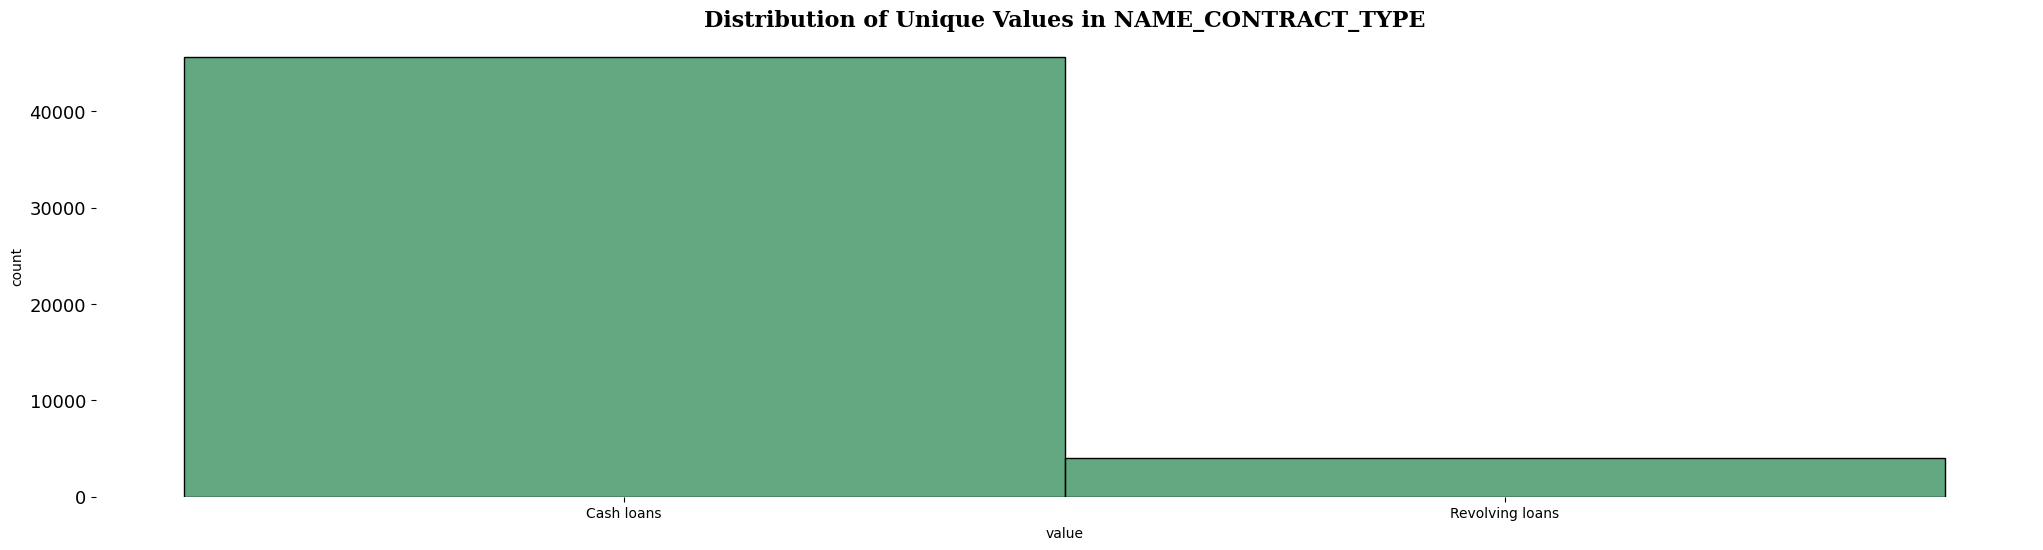

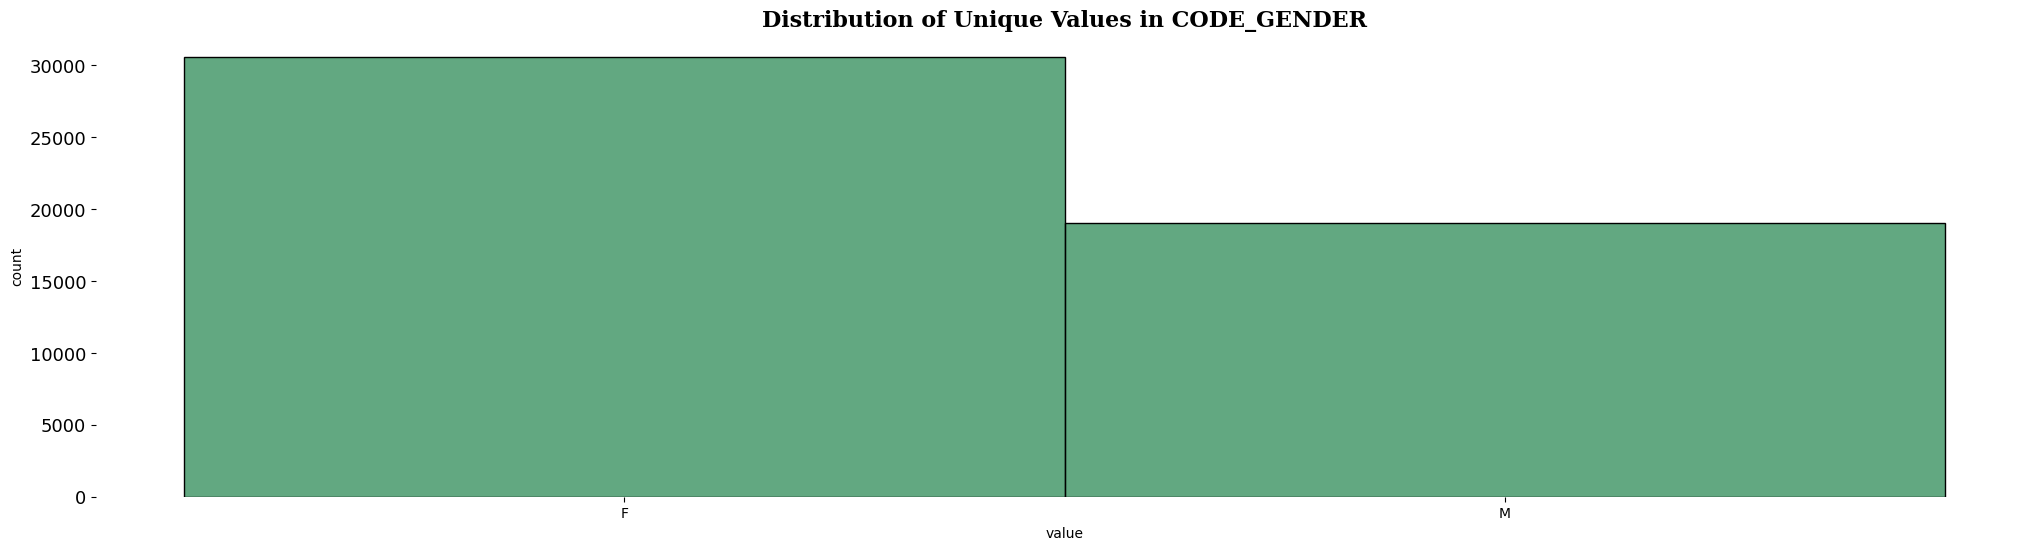

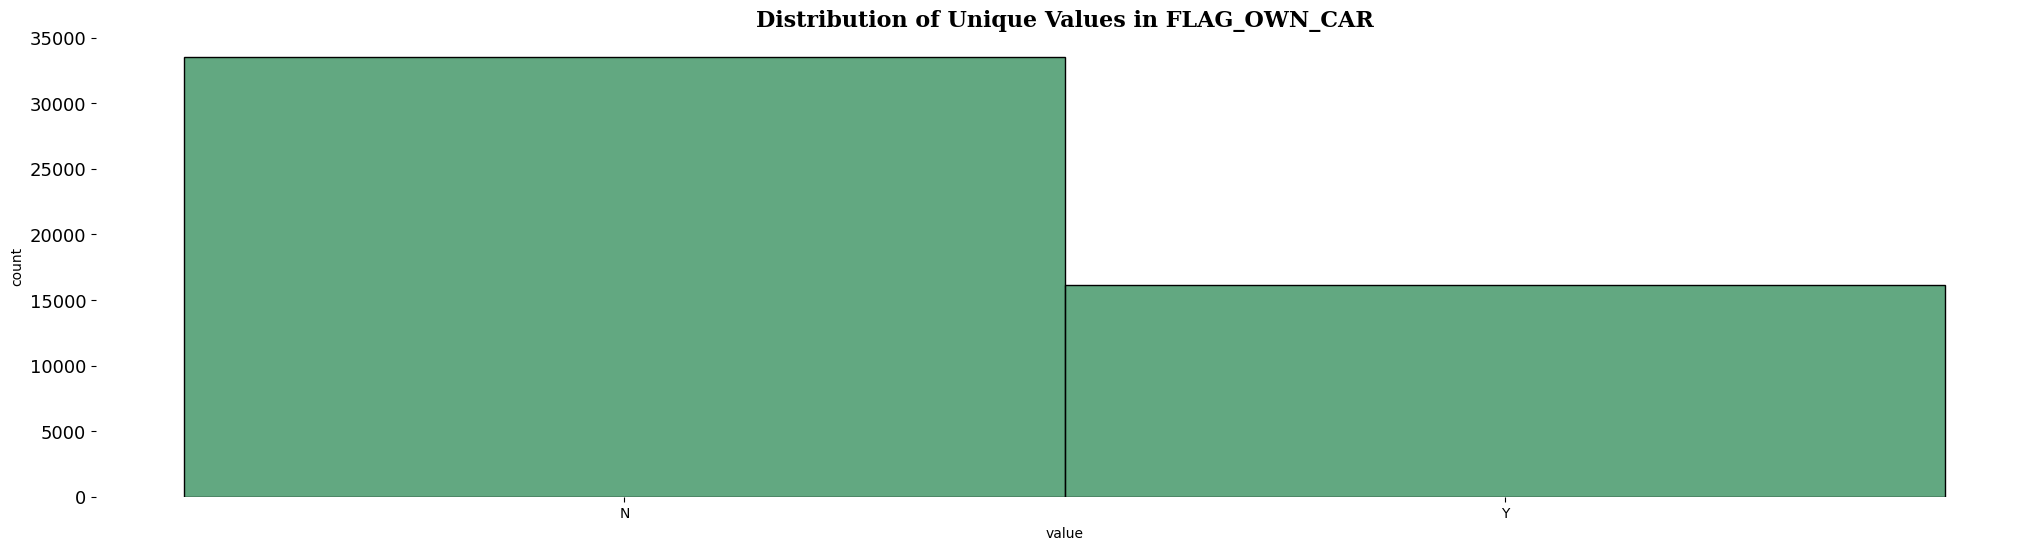

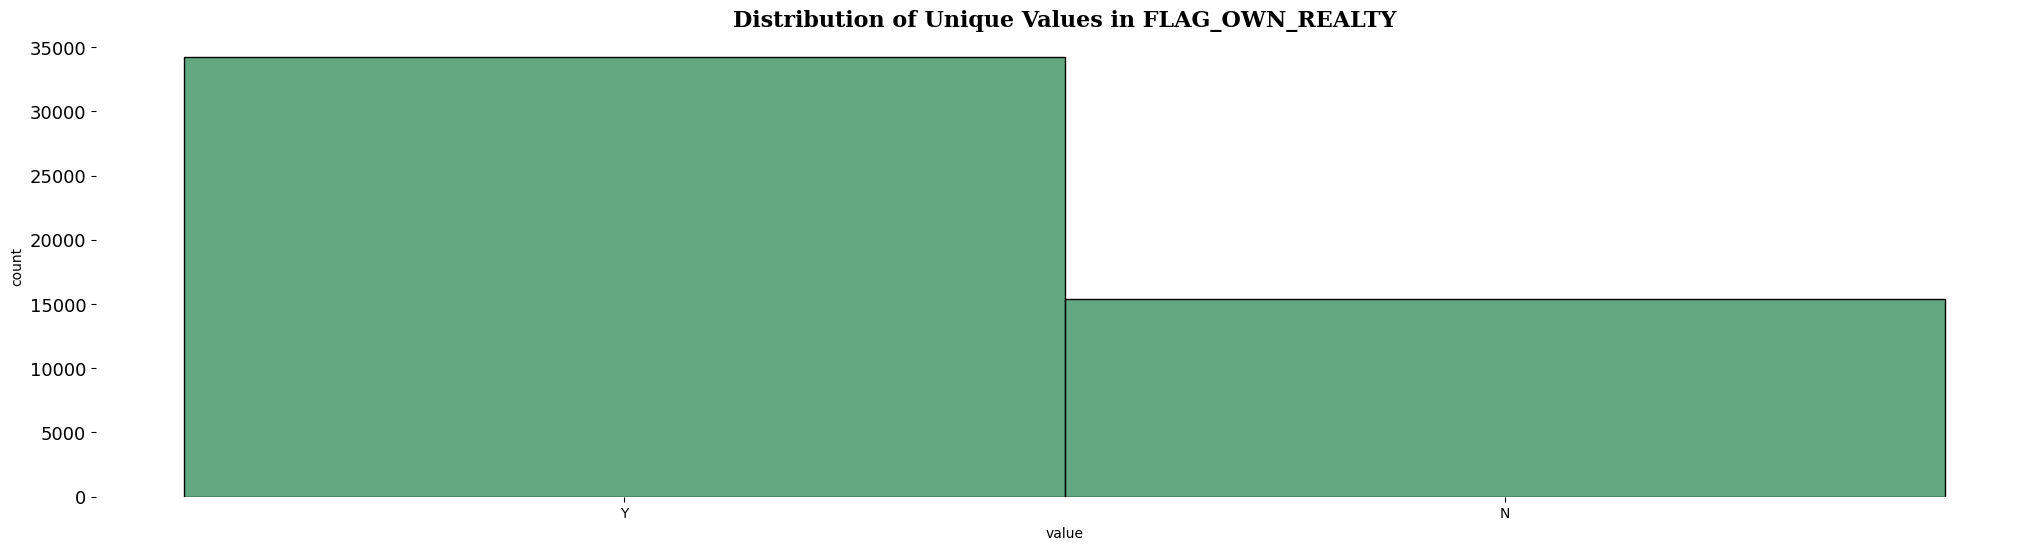

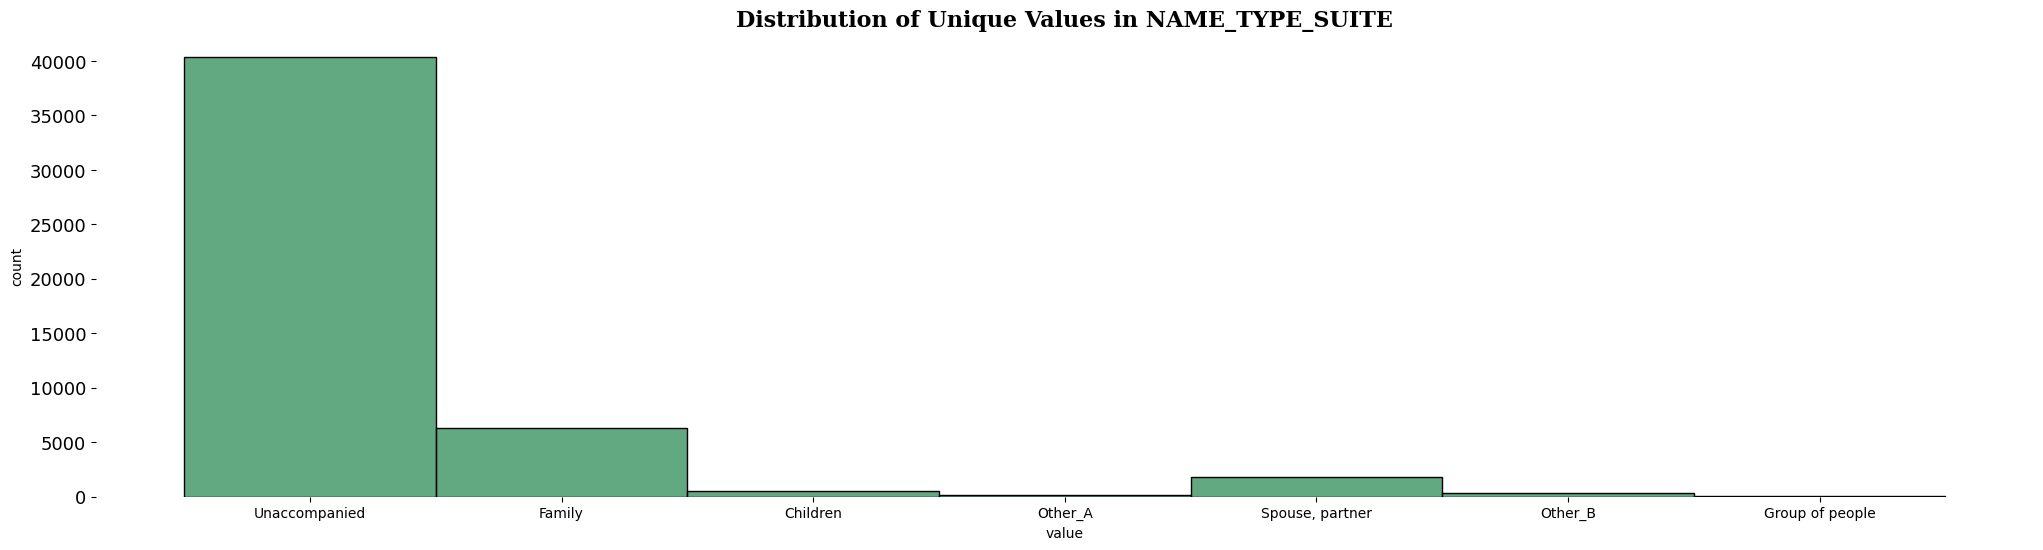

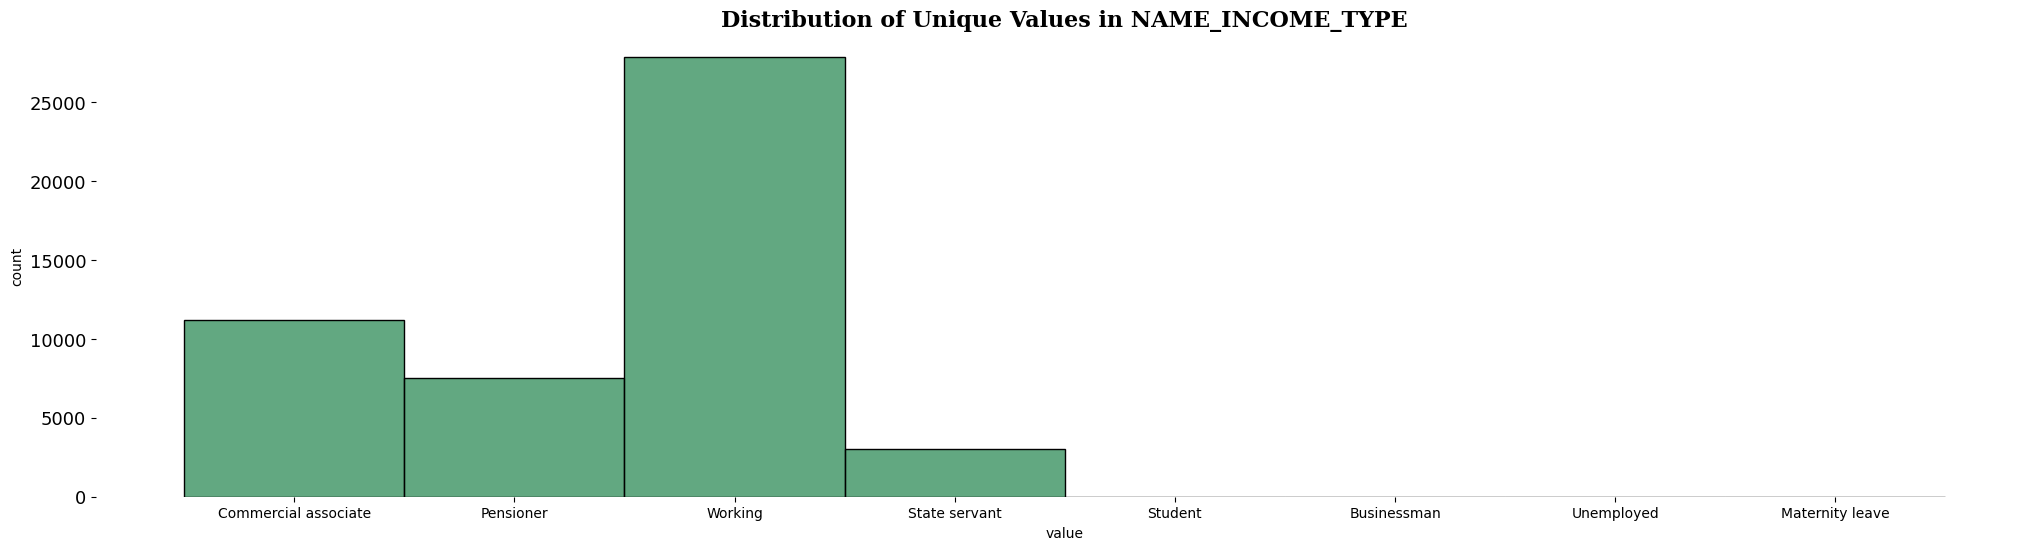

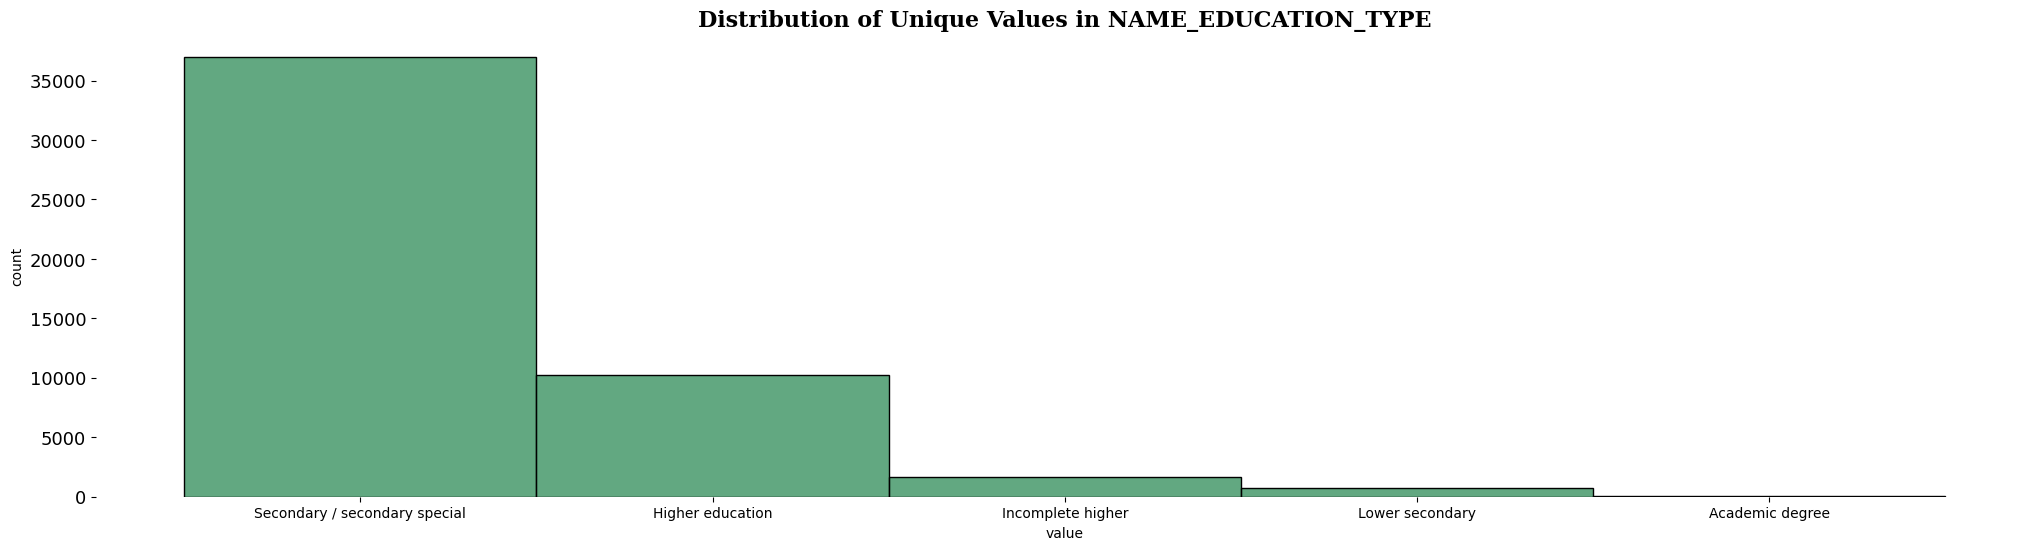

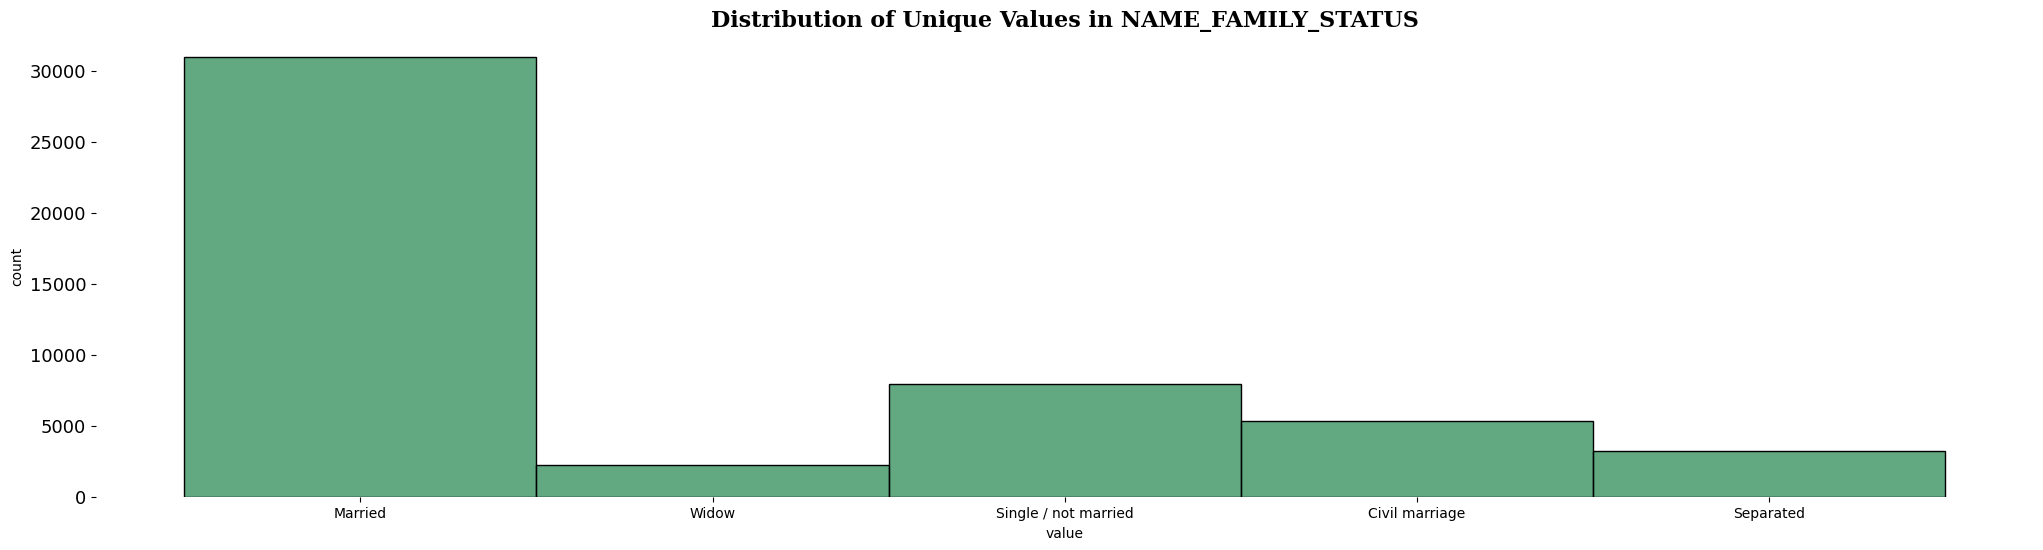

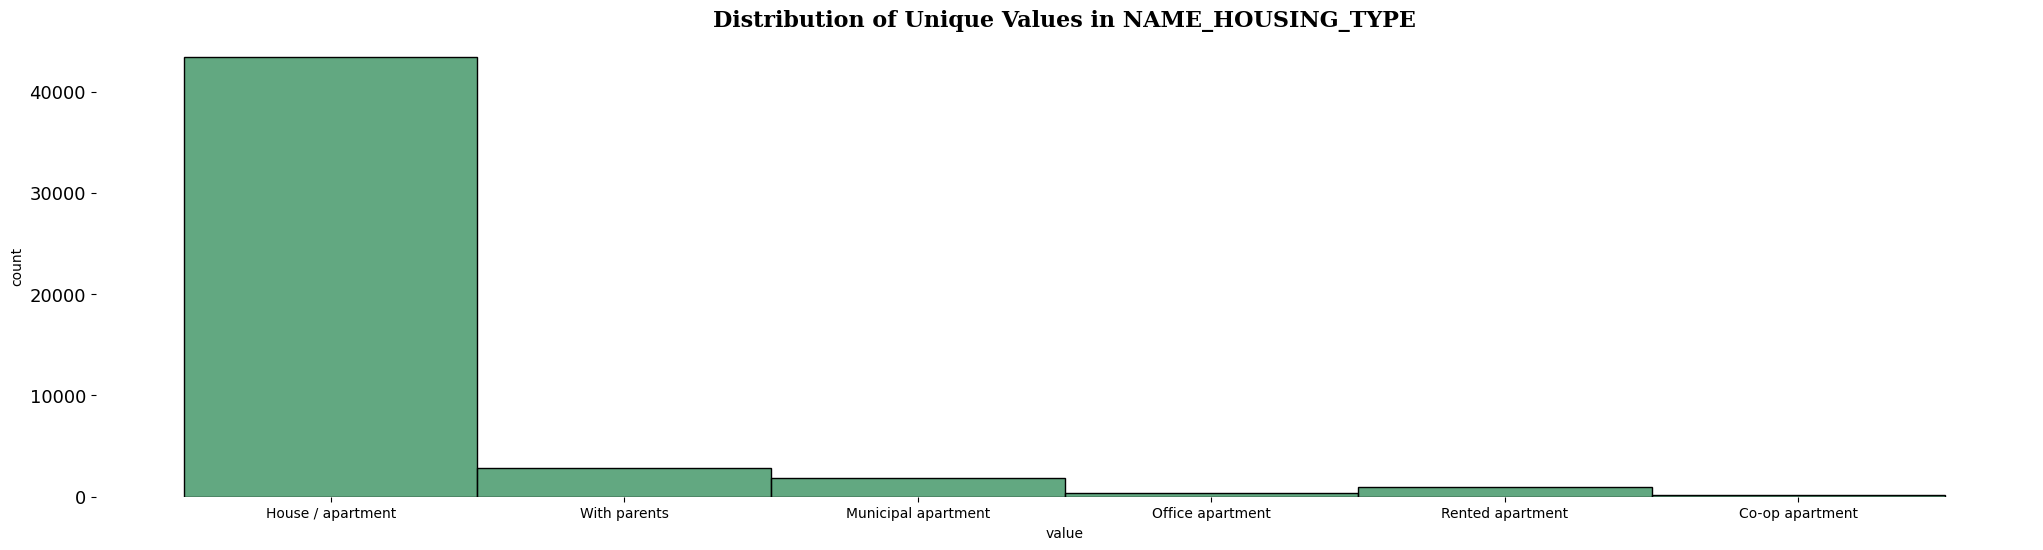

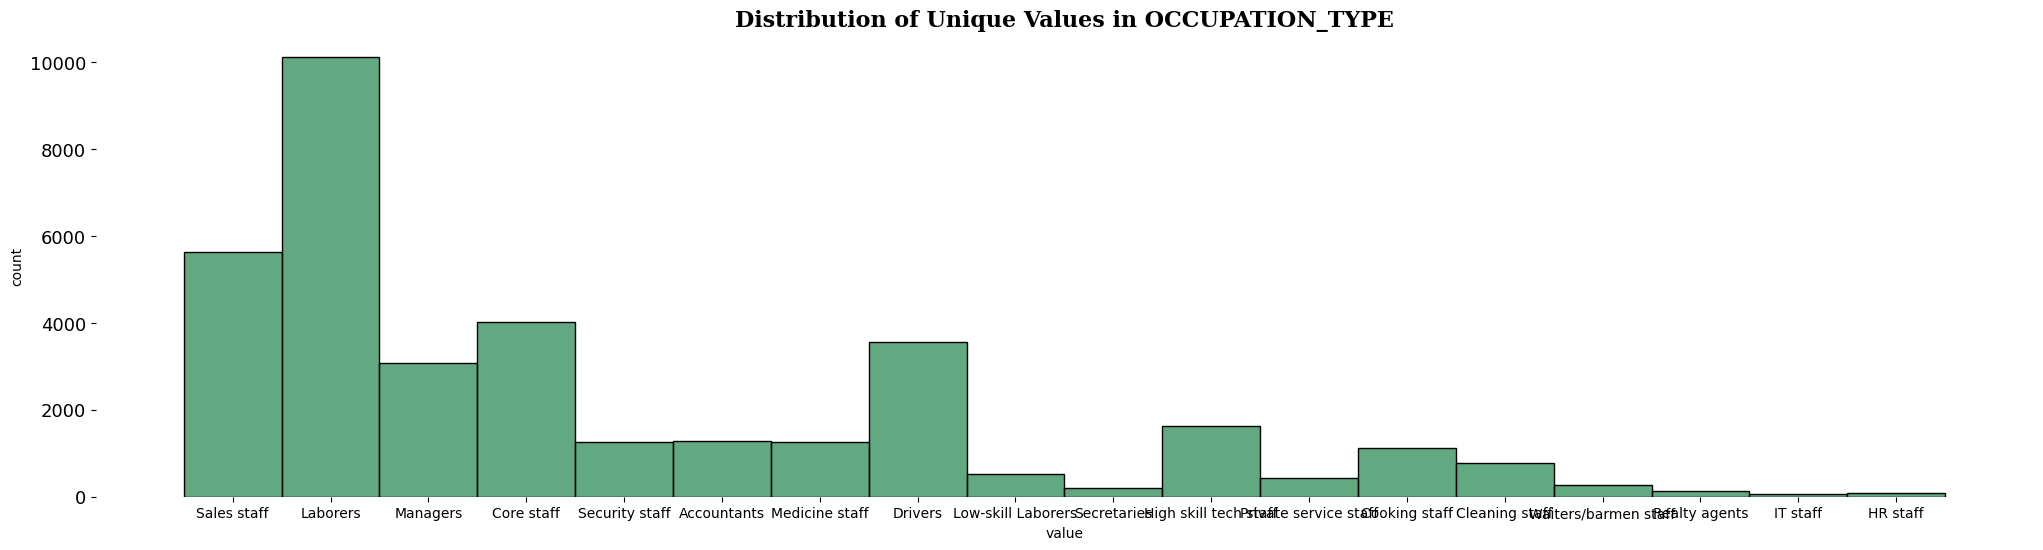

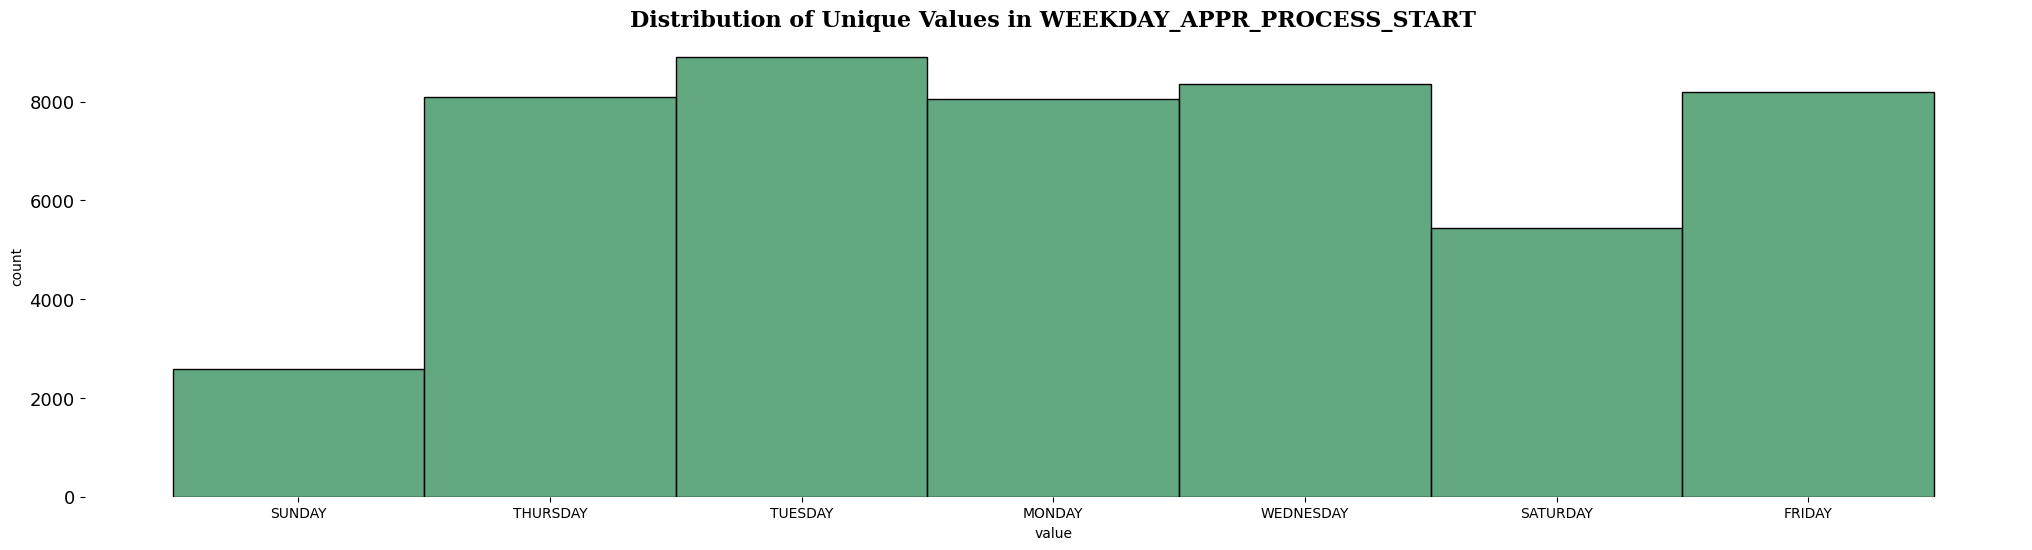

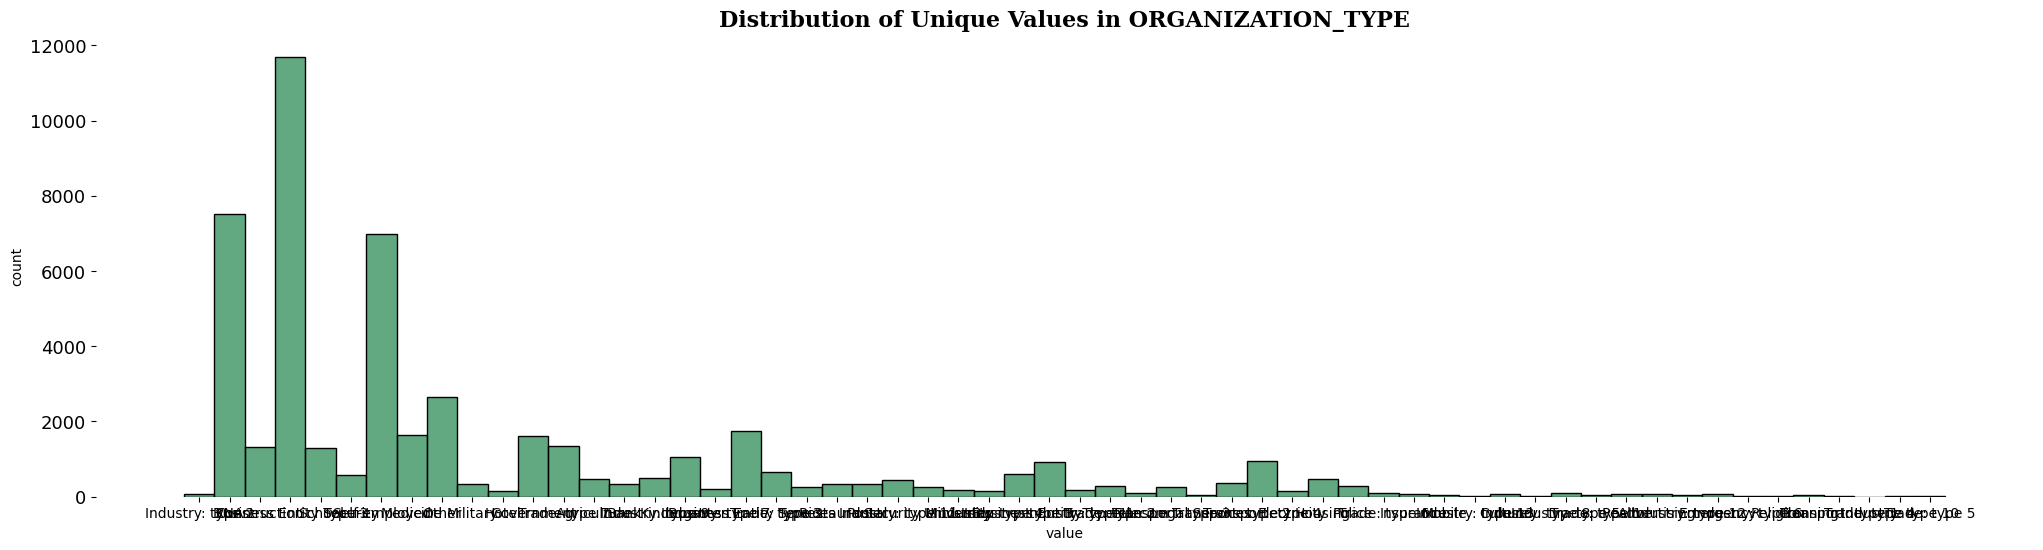

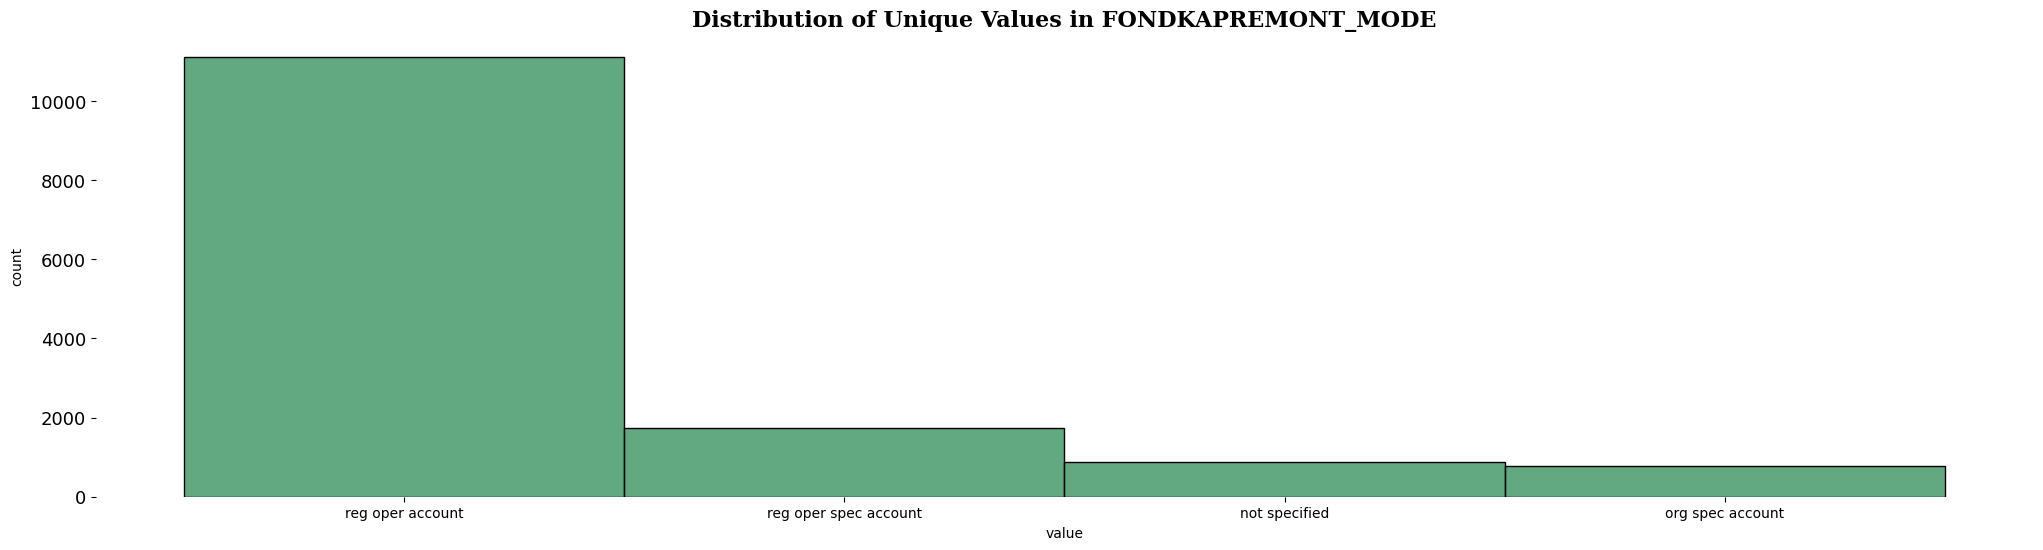

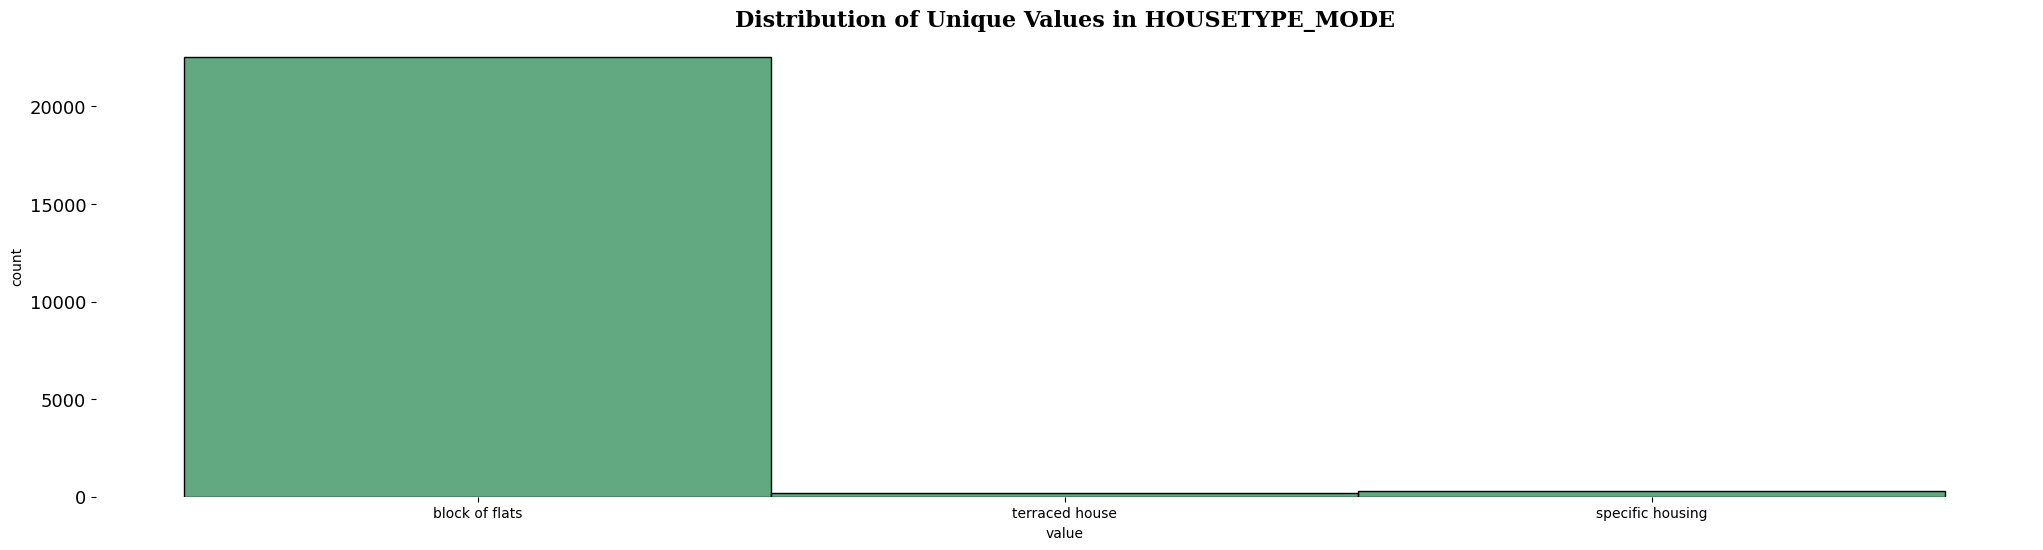

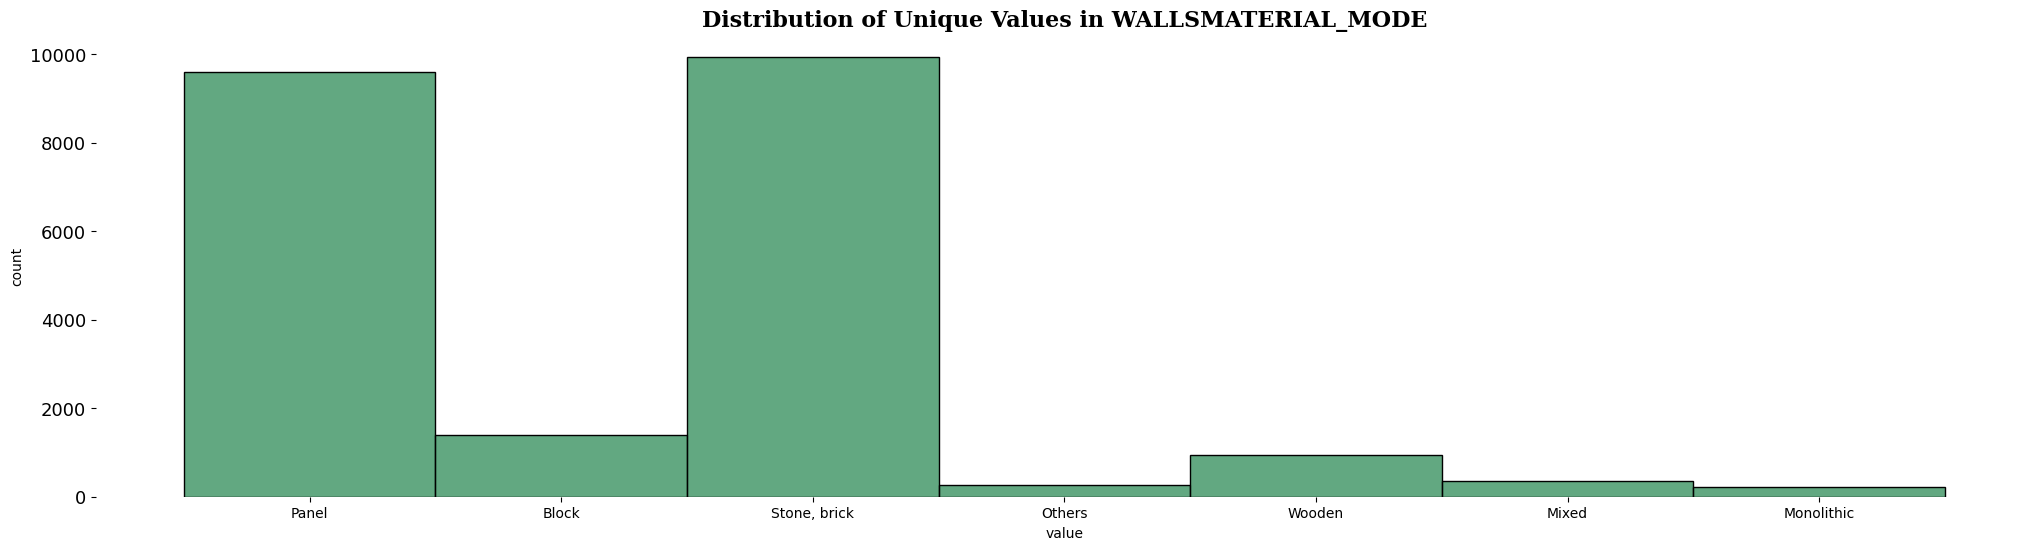

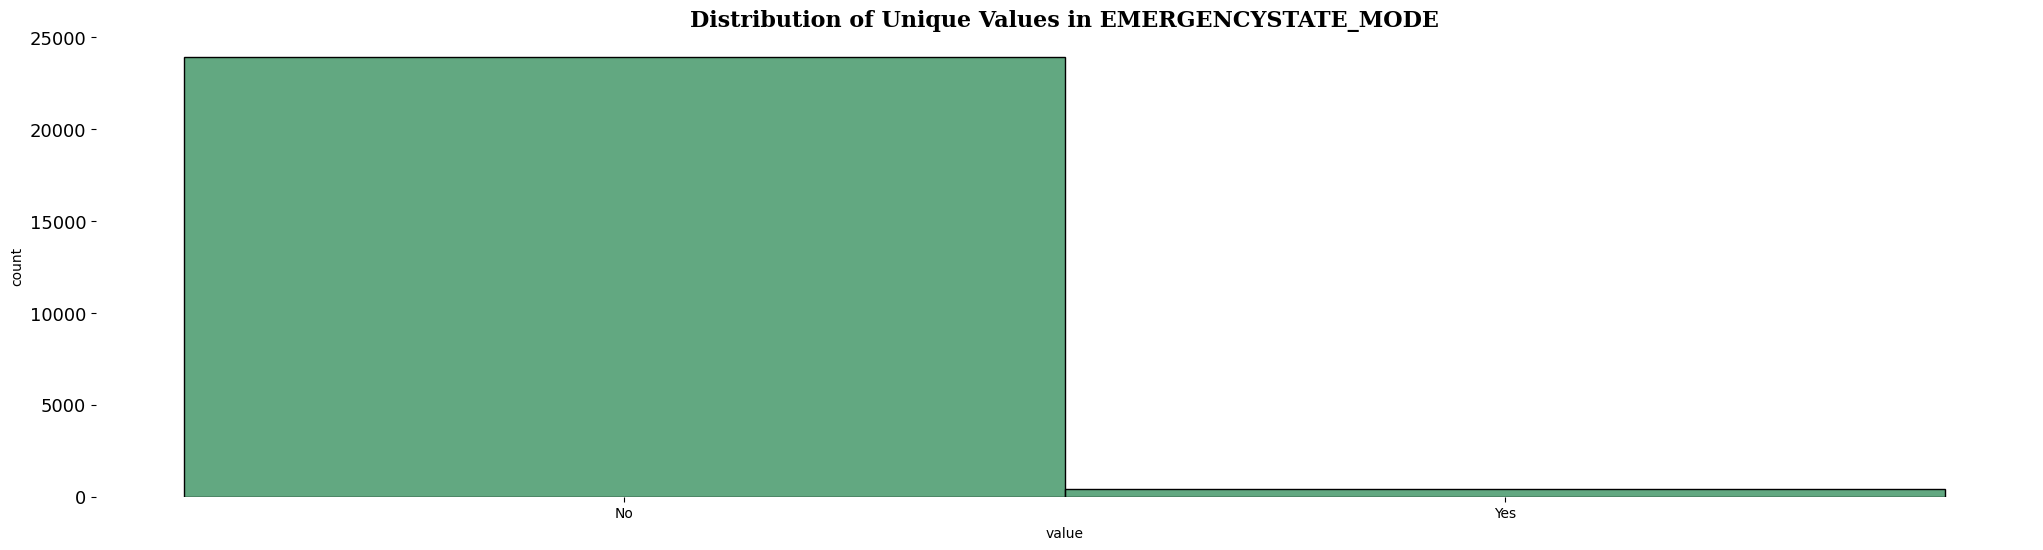

In [19]:
object_cols = balanced_df.select_dtypes("object").columns

for col in object_cols:
    unique_values = balanced_df[col].dropna().nunique()
    if unique_values < 100:
        fig, ax = plt.subplots(1,1, figsize=(25, 6))
        sns.histplot(balanced_df[col].dropna(), color='seagreen')
        plt.title('Distribution of Unique Values in {}'.format(col), fontsize=16, fontweight='bold', fontfamily='serif')
        plt.xlabel('value', fontsize=10)
        plt.ylabel('count', fontsize=10)
        plt.yticks(fontsize=13)
        plt.box(False)
        plt.show()


We'll visualize the relation between Target classes and the Features

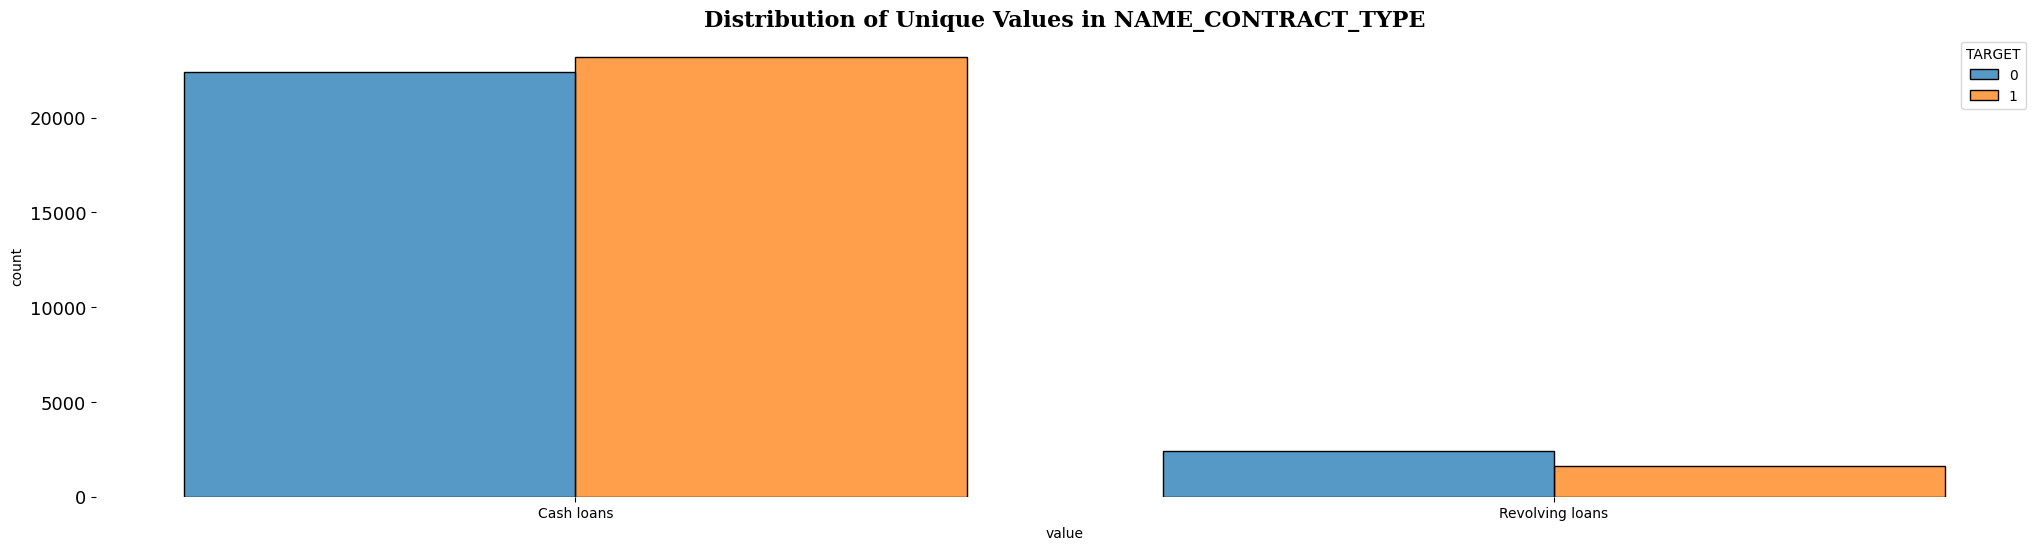

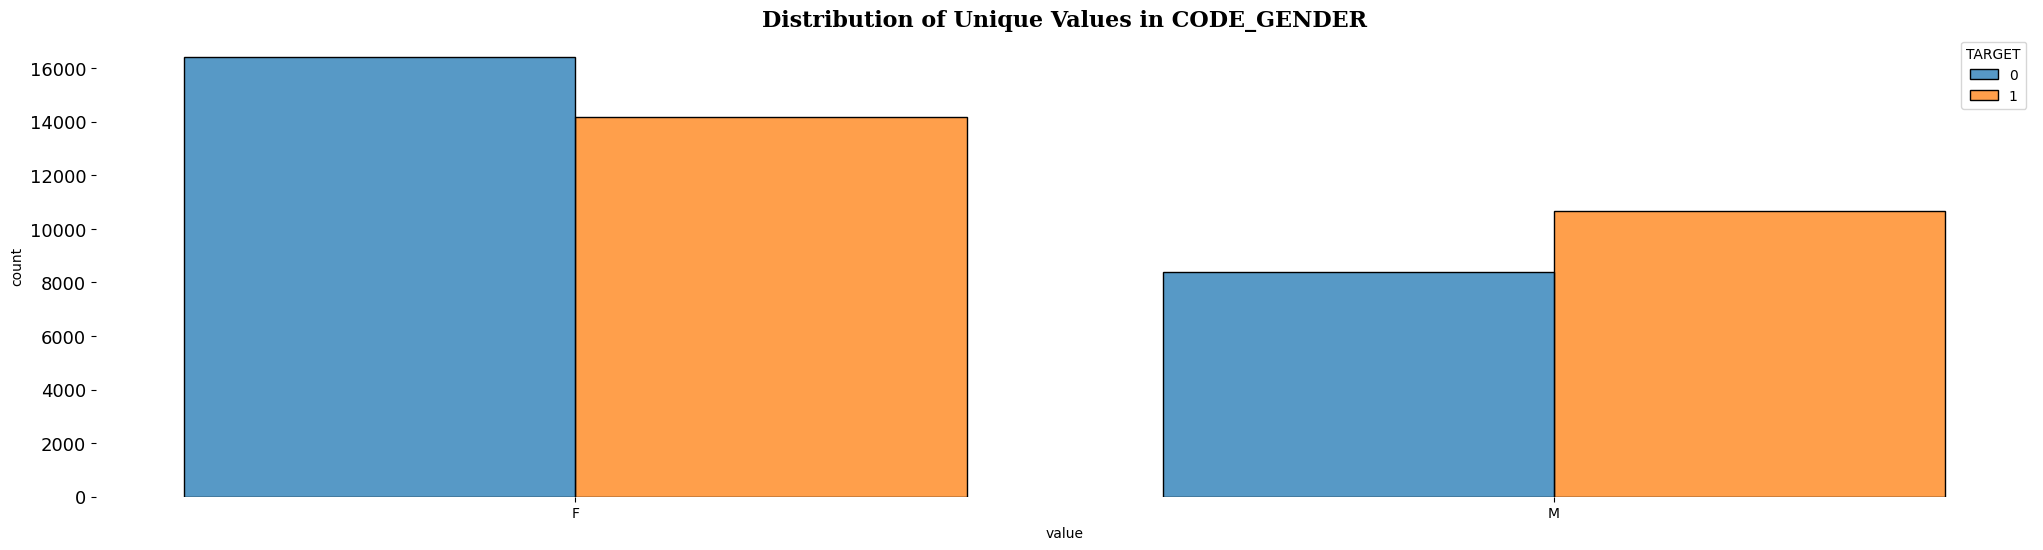

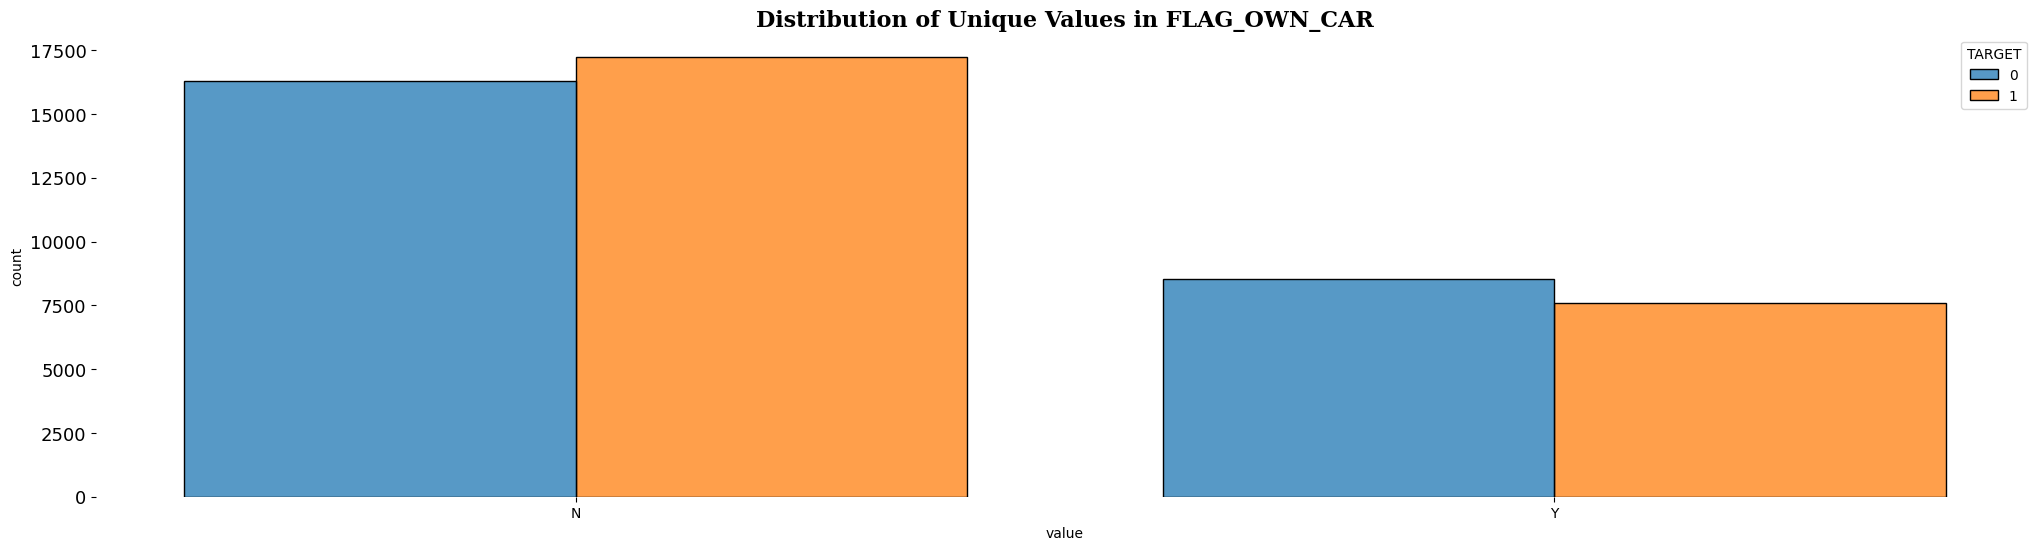

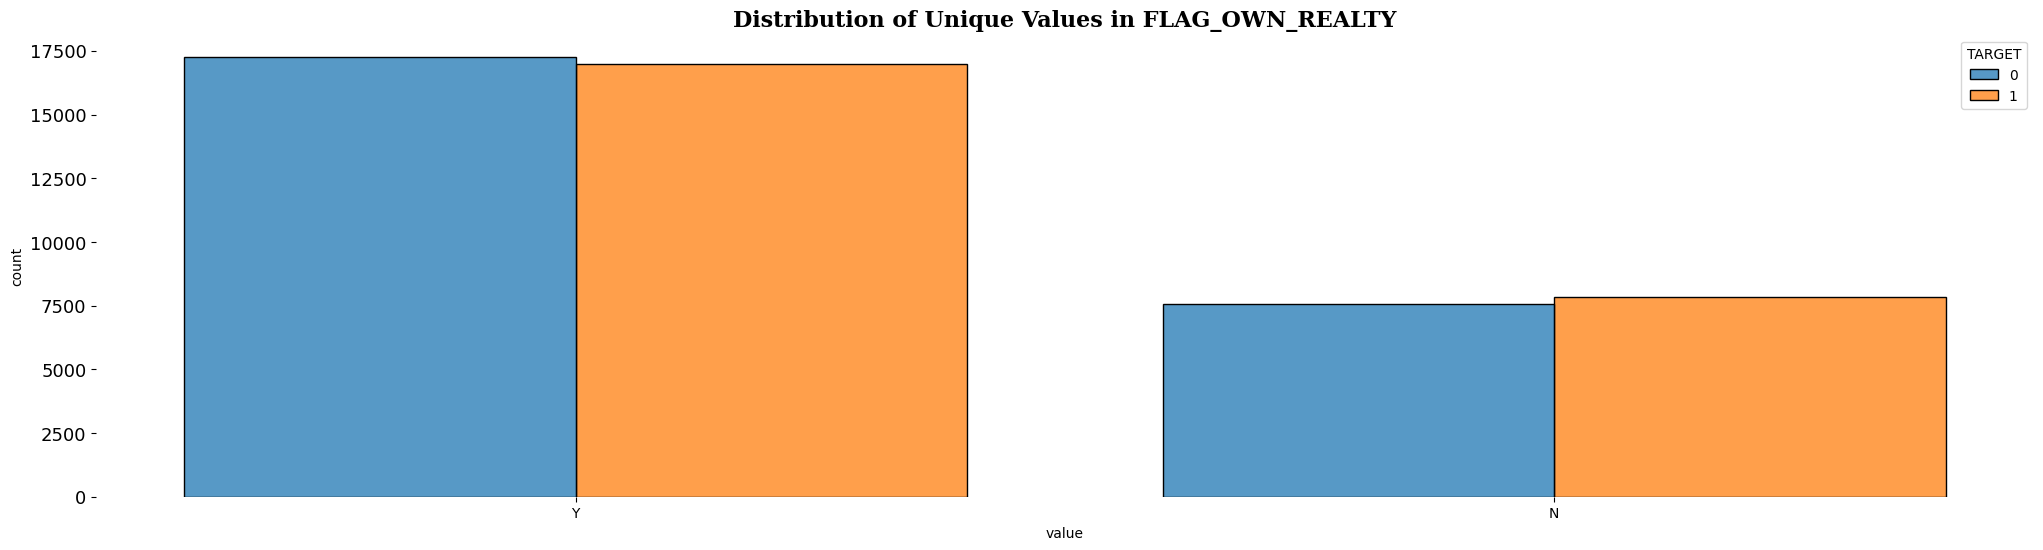

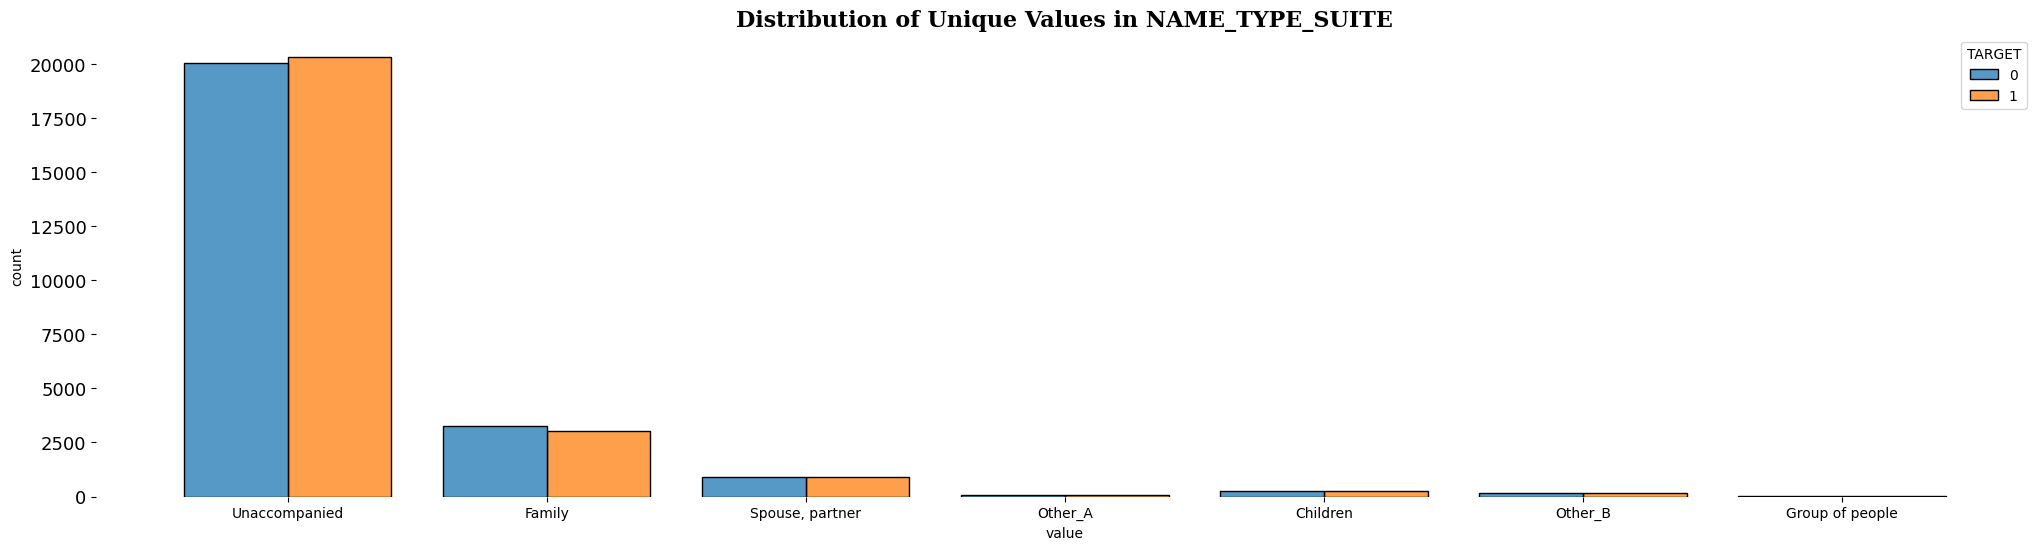

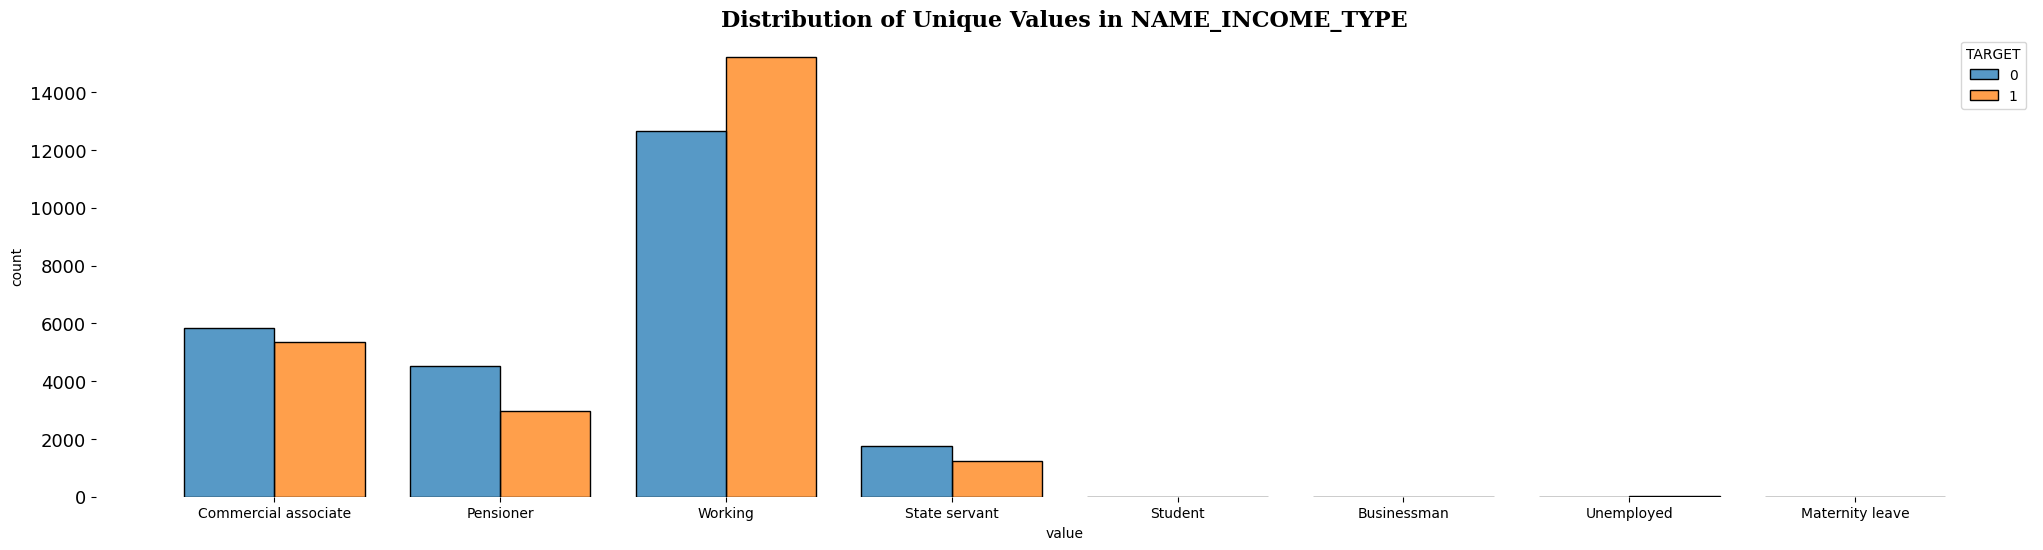

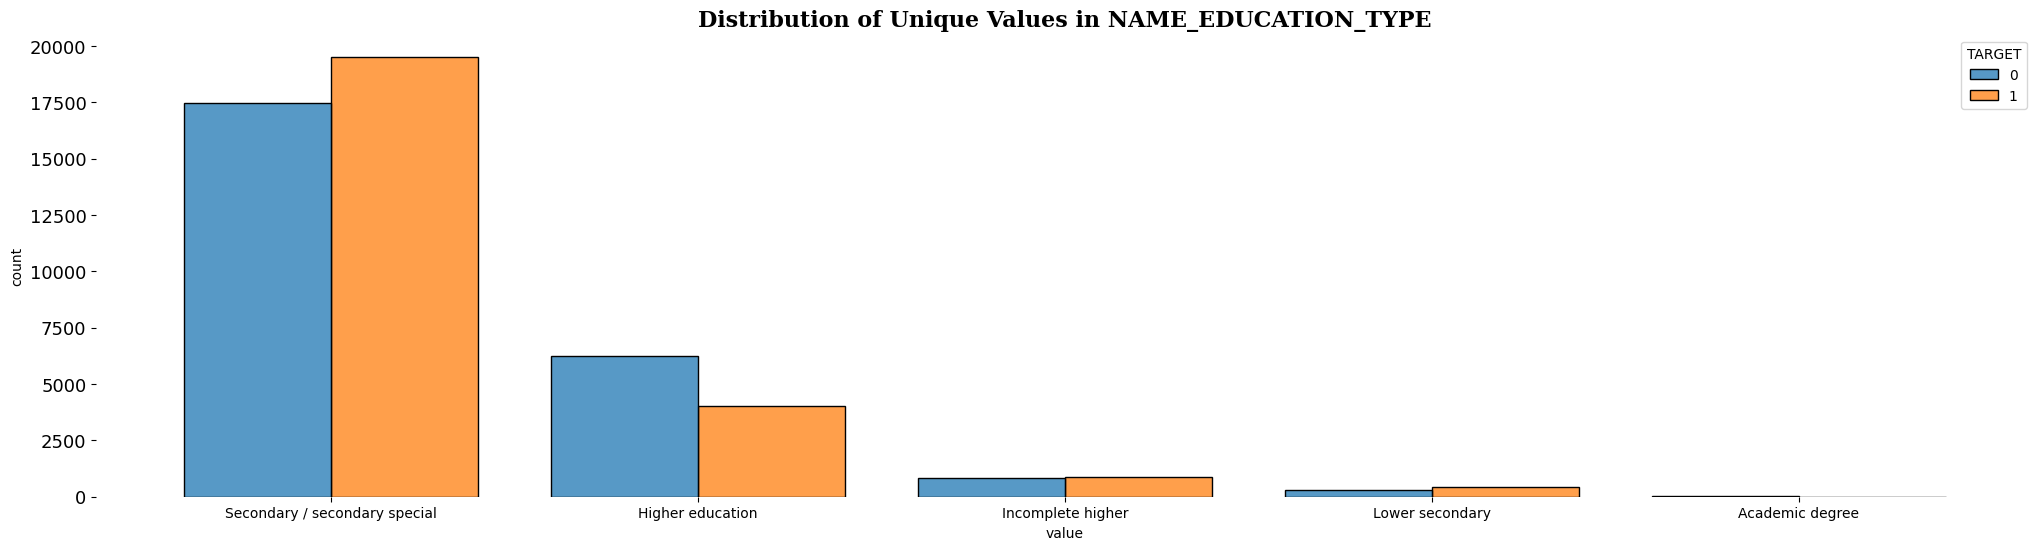

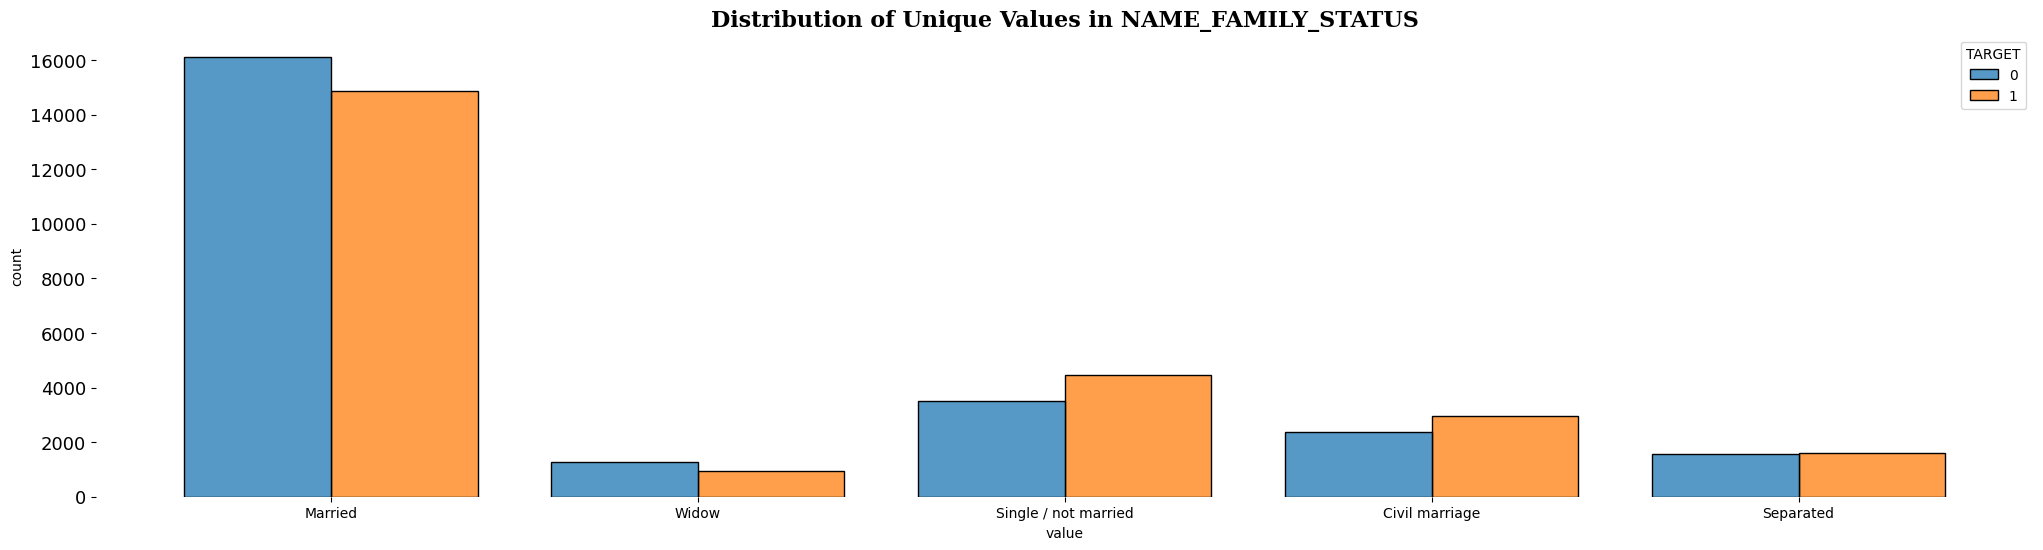

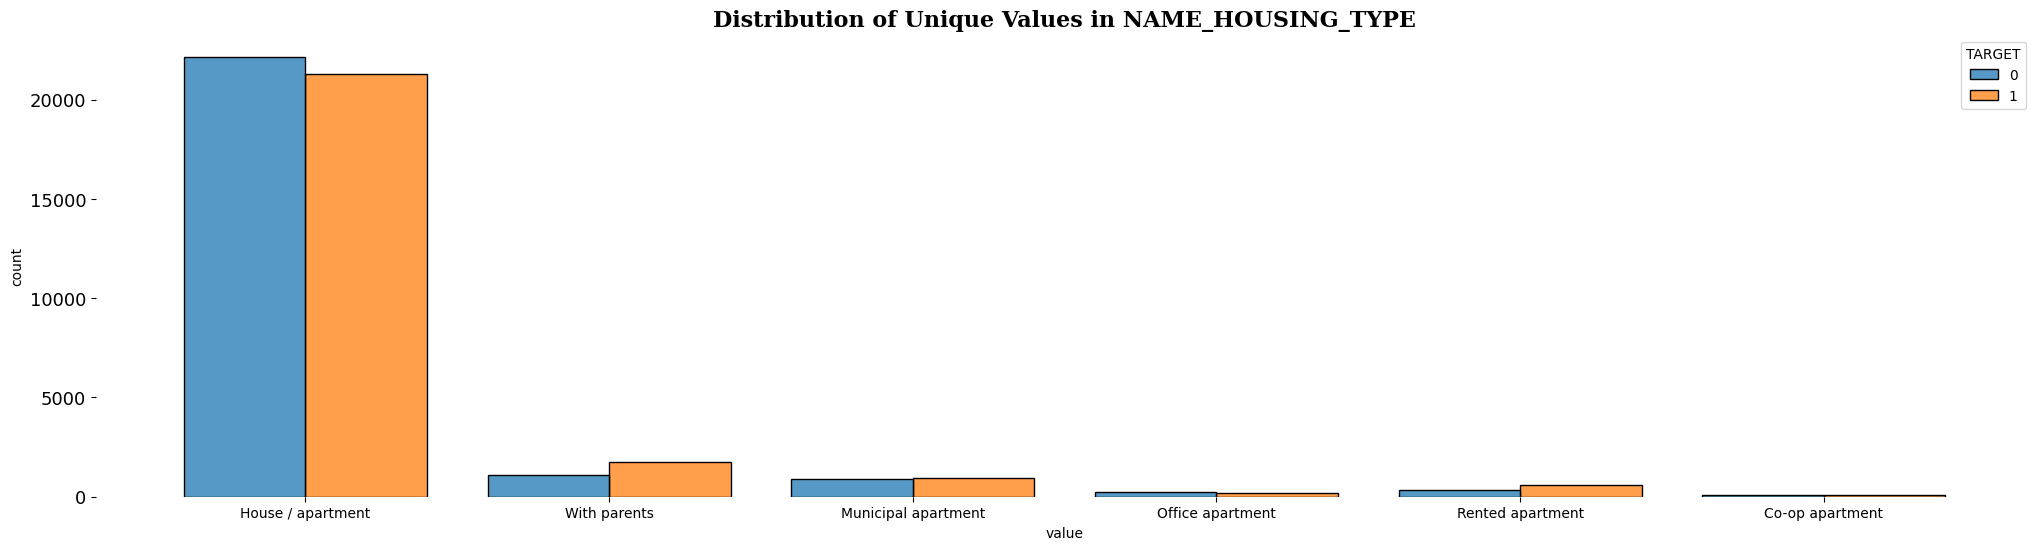

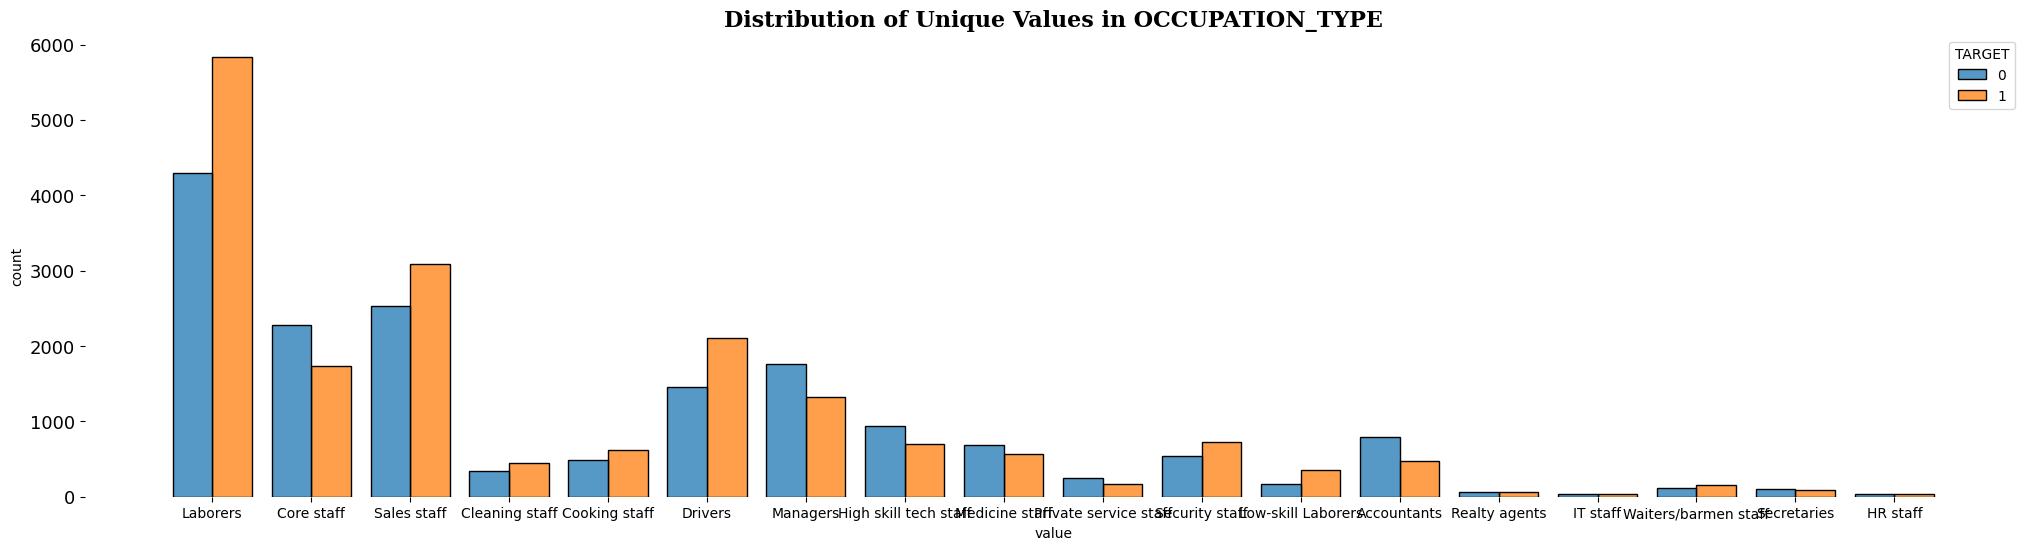

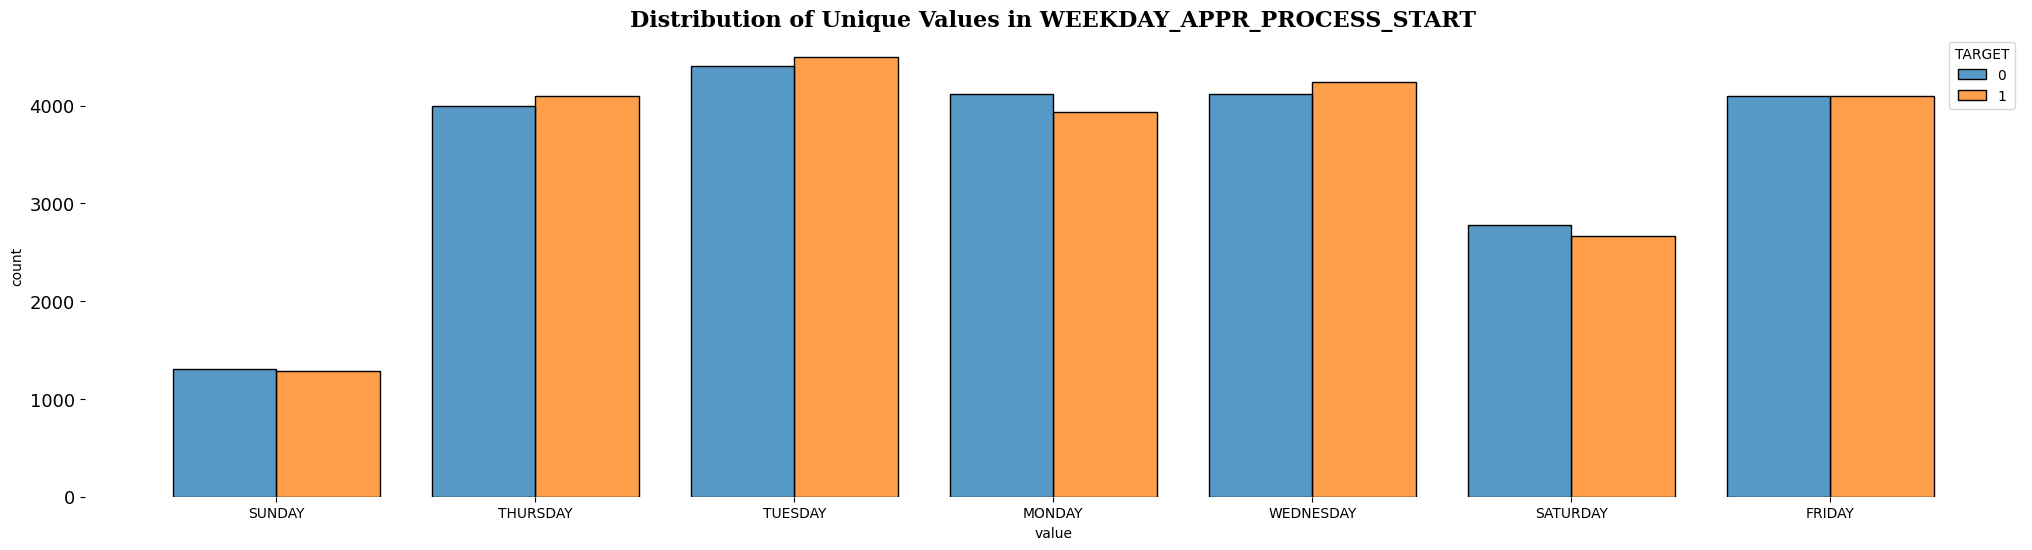

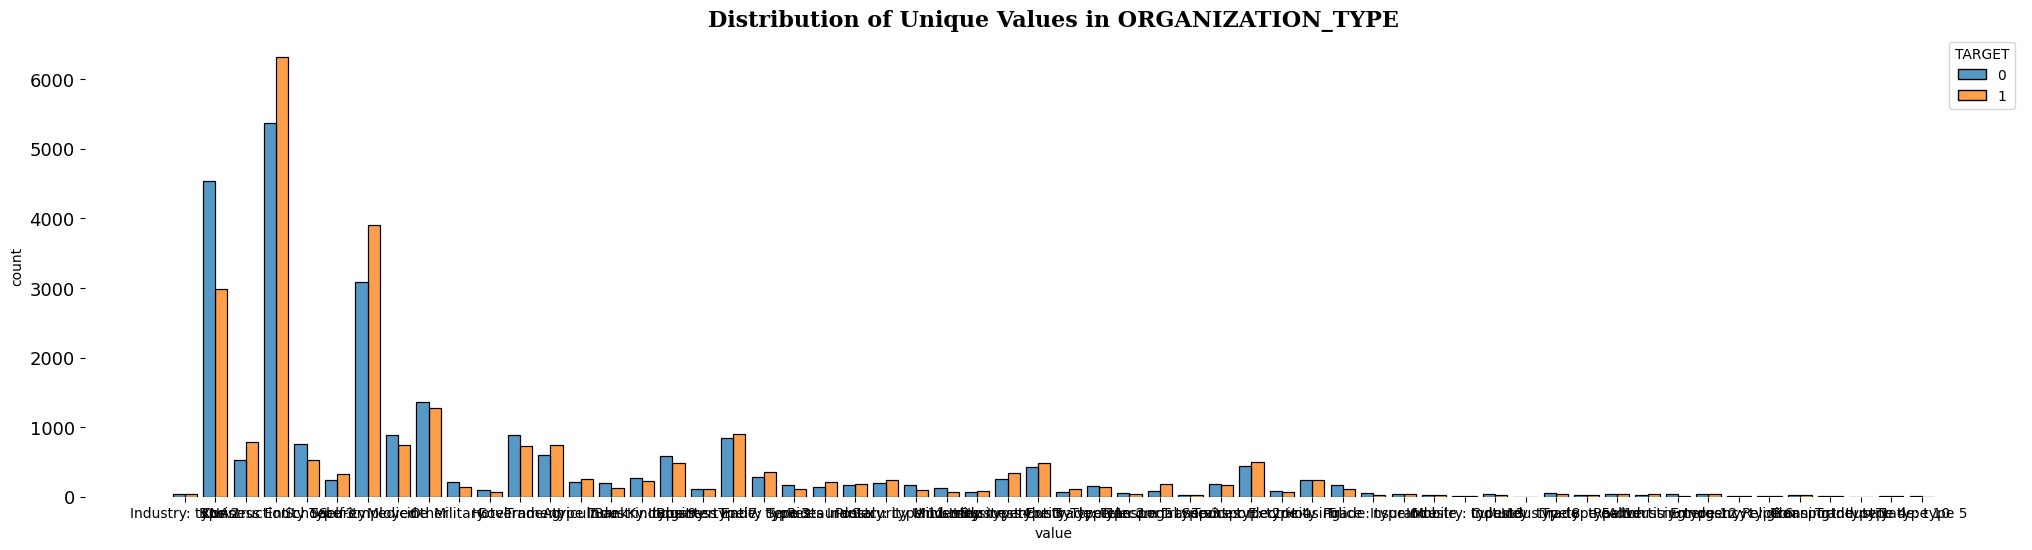

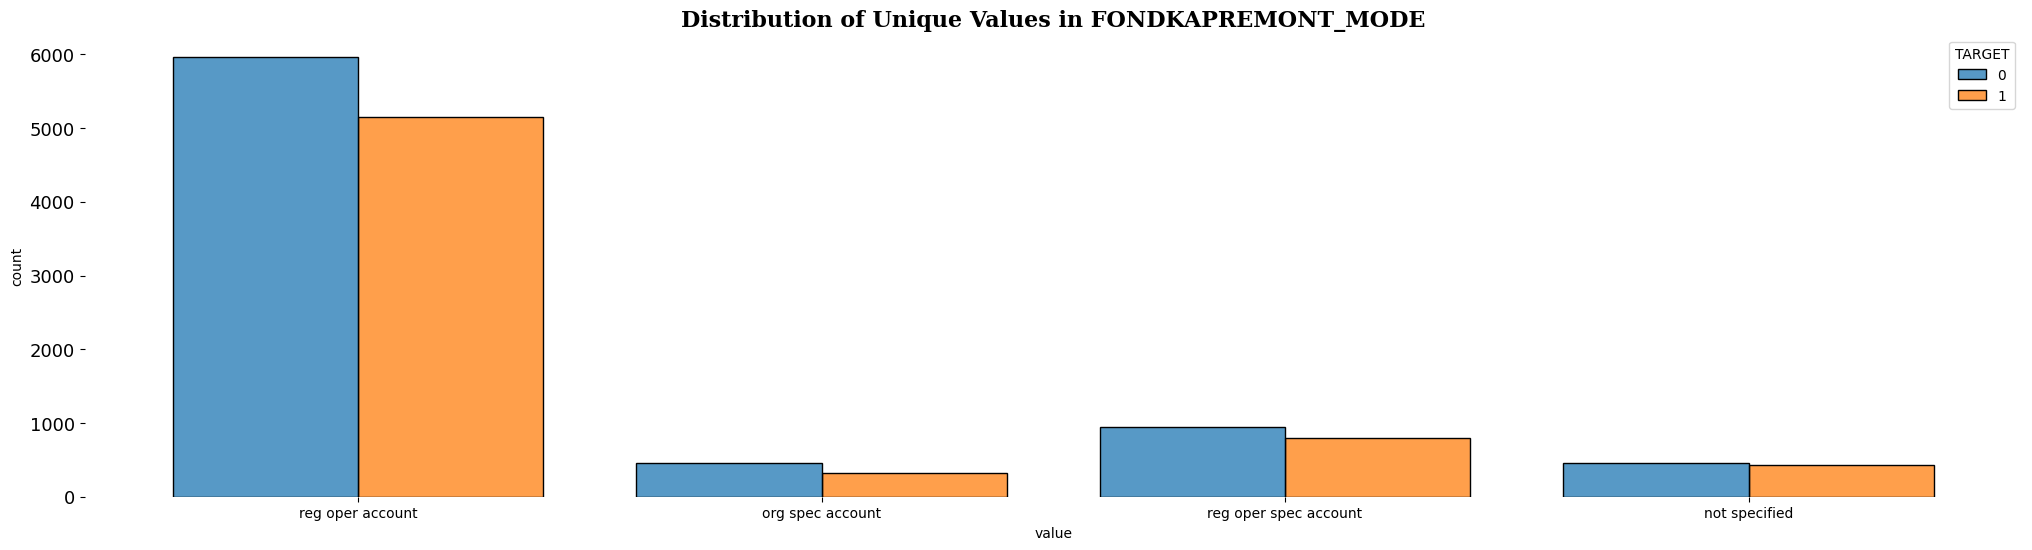

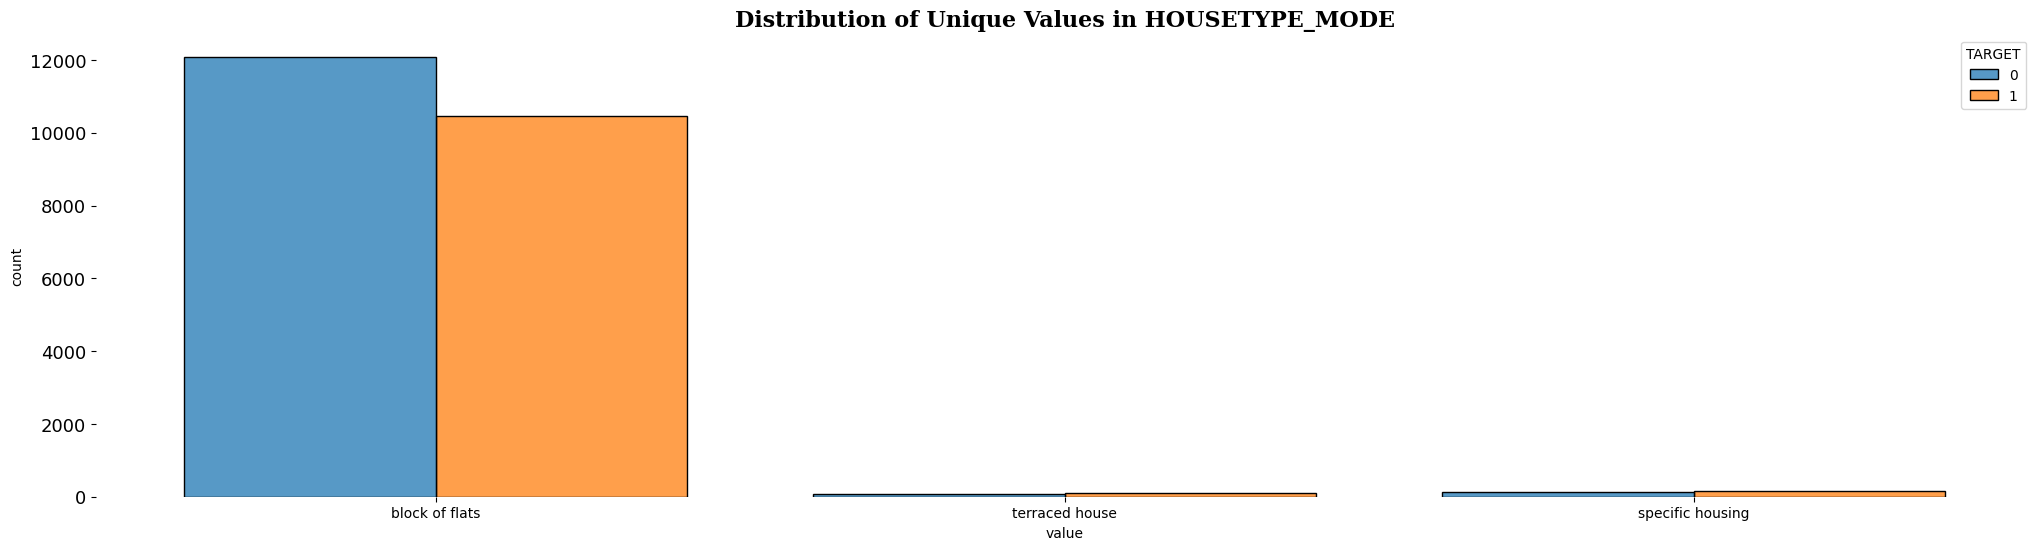

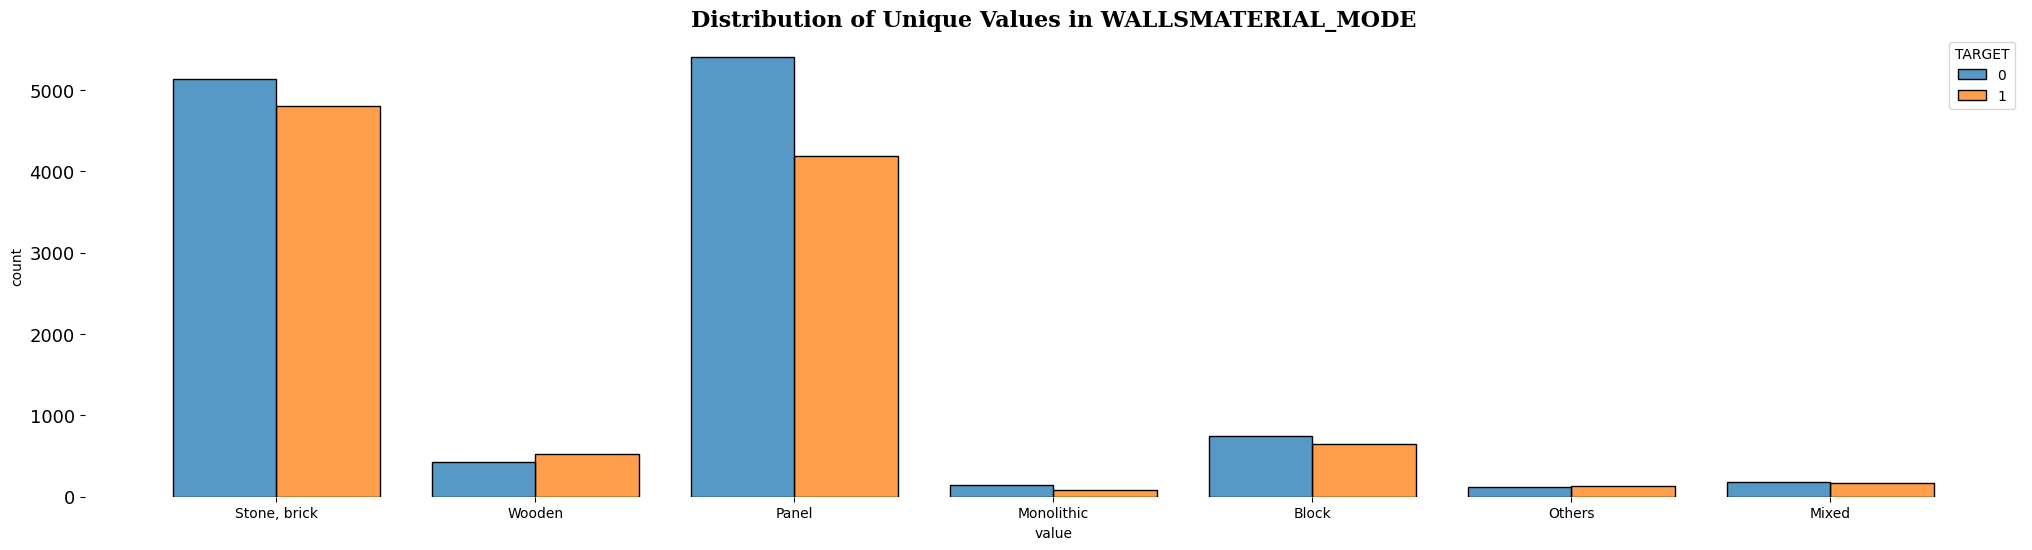

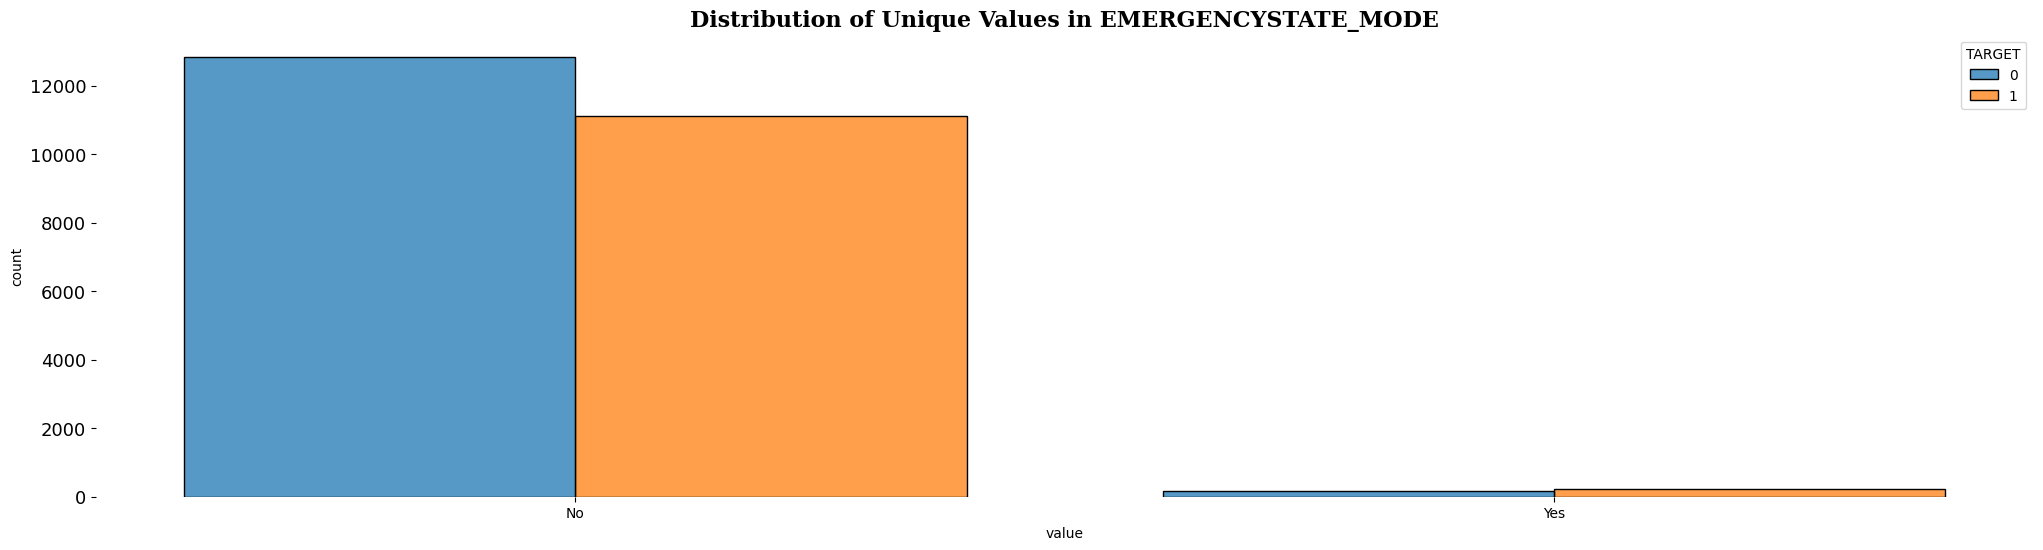

In [20]:
object_cols = balanced_df.select_dtypes("object").columns

for col in object_cols:
    unique_values = balanced_df[col].dropna().nunique()
    if unique_values < 100:
        fig, ax = plt.subplots(1,1, figsize=(25, 6))
        sns.histplot(x=balanced_df[col].dropna(), hue=balanced_df["TARGET"], multiple="dodge", shrink=.8)
        plt.title('Distribution of Unique Values in {}'.format(col), fontsize=16, fontweight='bold', fontfamily='serif')
        plt.xlabel('value', fontsize=10)
        plt.ylabel('count', fontsize=10)
        plt.yticks(fontsize=13)
        plt.box(False)
        plt.show()


## Feature Selection

In [21]:
high_correlation =correlation[((correlation > 0.03) | (correlation < -0.03)) & (correlation < 1) ]
high_correlation

NameError: name 'correlation' is not defined

In [ ]:
# For each feature, list its correlated feature
correlated_columns = {}
for col in high_correlation.columns:
    correlated_features = high_correlation.columns[(~high_correlation[col].isna())].tolist()
    correlated_features = list(set(correlated_features).difference(set(correlated_columns.keys())))
    correlated_columns[col] = correlated_features

In [ ]:
# From correlated features with TARGET, select their top 3 correlated features
selected_features = correlated_columns["TARGET"]
for feature in selected_features.copy():
    correlated_correlated_features = high_correlation[feature].abs().sort_values(ascending=False)    
    features_to_select = correlated_correlated_features[correlated_correlated_features < 90][:3].index.tolist()
    selected_features.extend(features_to_select)

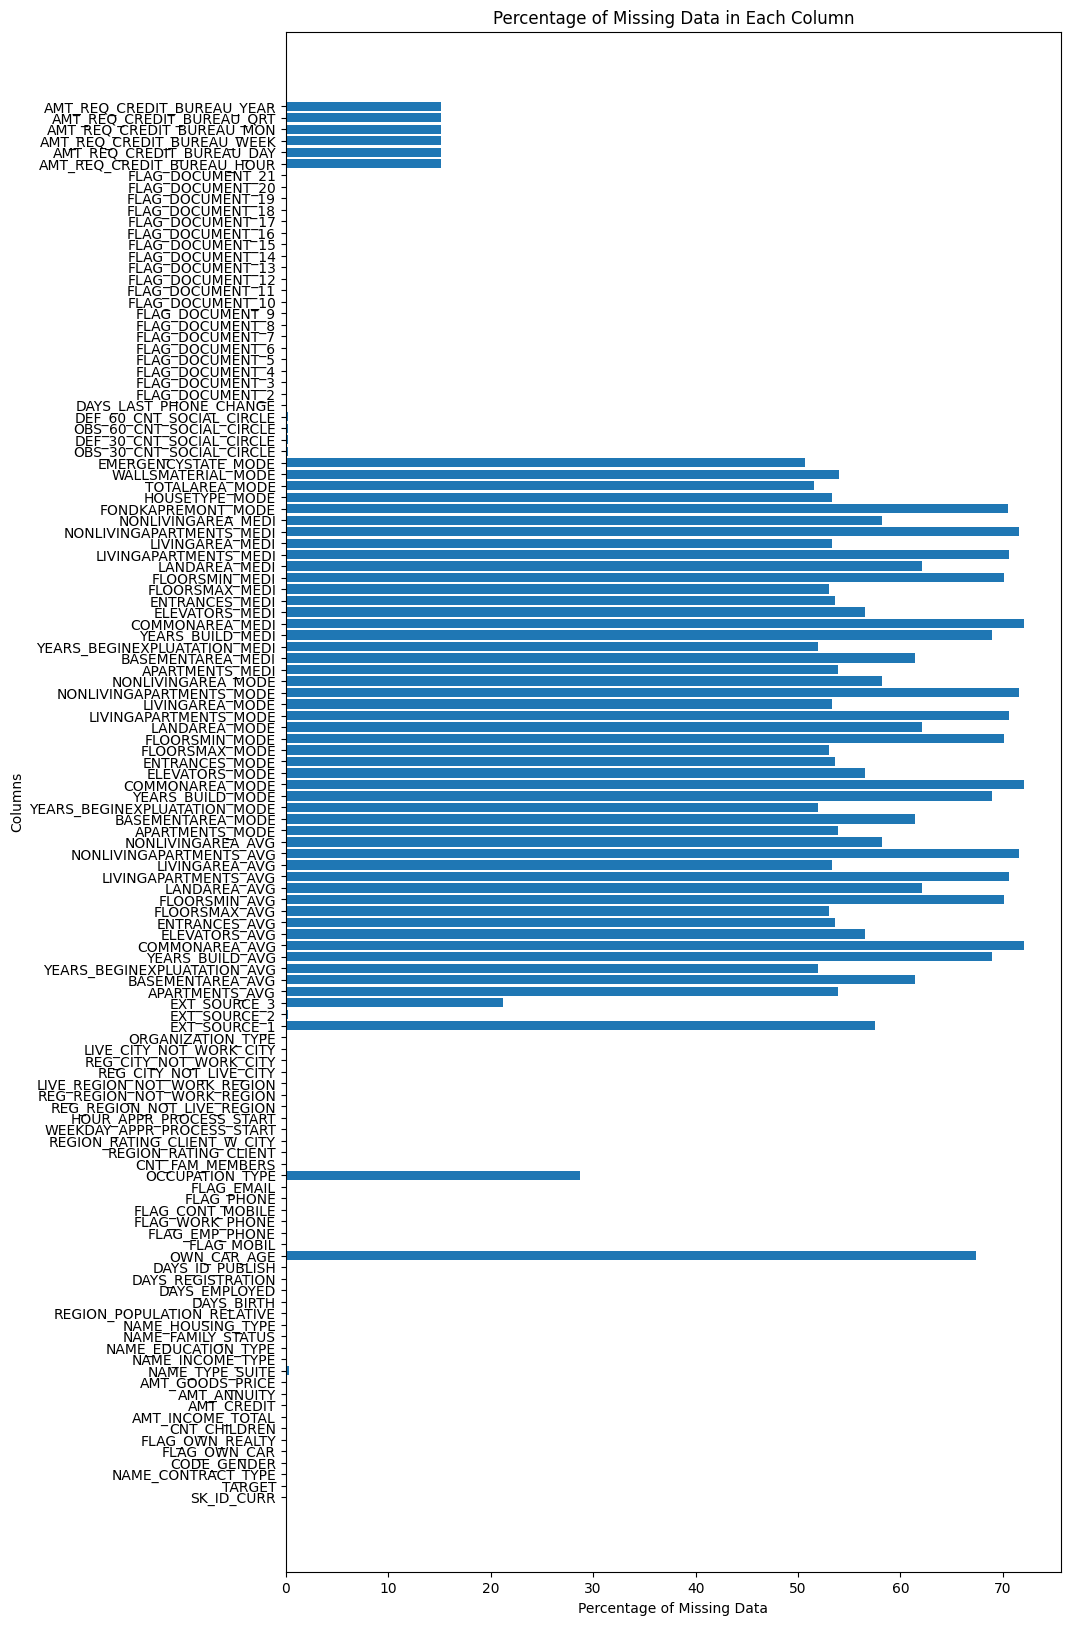

In [ ]:
whole = len(balanced_df)
missing_percentages = []

for col in balanced_df.columns:
    part = balanced_df[col].isna().sum()
    percentage = (part / whole) * 100
    missing_percentages.append(percentage)


plt.figure(figsize=(10, 20))
plt.barh(balanced_df.columns, missing_percentages)  # Use barh() for horizontal bar plot
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Columns')
plt.title('Percentage of Missing Data in Each Column')
plt.show()

Considering the previous analisys is better to drop the columns with high volume of missing data

In [ ]:
# Fill EXT_SOURCE_1 given EXT_SOURCE_2 and EXT_SOURCE_3

data = balanced_df.loc[:, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].dropna()
x_filler = data.drop(columns="EXT_SOURCE_1")
y_filler = data["EXT_SOURCE_1"]

reg_model = Ridge(alpha=0.001)
reg_model.fit(x_filler, y_filler)

mask = (~(balanced_df["EXT_SOURCE_2"].isna())) & (~(balanced_df["EXT_SOURCE_3"].isna())) & (balanced_df["EXT_SOURCE_1"].isna())
x_pred = balanced_df.loc[mask,["EXT_SOURCE_2", "EXT_SOURCE_3"]]
balanced_df.loc[mask,"EXT_SOURCE_1"] = reg_model.predict(x_pred)

In [ ]:
# Fill EXT_SOURCE_3 given EXT_SOURCE_2 and EXT_SOURCE_1

data = balanced_df.loc[:, ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].dropna()
x_filler = data.drop(columns="EXT_SOURCE_3")
y_filler = data["EXT_SOURCE_3"]

reg_model = Ridge(alpha=0.001)
reg_model.fit(x_filler, y_filler)

mask = (~(balanced_df["EXT_SOURCE_2"].isna())) & (~(balanced_df["EXT_SOURCE_1"].isna())) & (balanced_df["EXT_SOURCE_3"].isna())
x_pred = balanced_df.loc[mask,["EXT_SOURCE_1", "EXT_SOURCE_2"]]
balanced_df.loc[mask,"EXT_SOURCE_3"] = reg_model.predict(x_pred)

In [ ]:
# Fill remaining missings using median
balanced_df["EXT_SOURCE_1"] = balanced_df["EXT_SOURCE_1"].fillna(balanced_df["EXT_SOURCE_1"].median())
balanced_df["EXT_SOURCE_2"] = balanced_df["EXT_SOURCE_2"].fillna(balanced_df["EXT_SOURCE_2"].median())
balanced_df["EXT_SOURCE_3"] = balanced_df["EXT_SOURCE_3"].fillna(balanced_df["EXT_SOURCE_3"].median())
balanced_df["DAYS_LAST_PHONE_CHANGE"] = balanced_df["DAYS_LAST_PHONE_CHANGE"].fillna(balanced_df["DAYS_LAST_PHONE_CHANGE"].median())

# Fill remaining missings using mean
balanced_df["AMT_ANNUITY"] = balanced_df["AMT_ANNUITY"].fillna(balanced_df["AMT_ANNUITY"].mean())
balanced_df["AMT_GOODS_PRICE"] = balanced_df["AMT_GOODS_PRICE"].fillna(balanced_df["AMT_GOODS_PRICE"].mean())
balanced_df["AMT_REQ_CREDIT_BUREAU_YEAR"] = balanced_df["AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(balanced_df["AMT_REQ_CREDIT_BUREAU_YEAR"].mean())


In [ ]:
X = balanced_df.drop(columns=["TARGET"]).copy()
y = balanced_df['TARGET']

In [ ]:
# Large portion of missing values -> better to drop column
X = X.drop(columns=["SK_ID_CURR",
    "FLOORSMIN_MODE",
    "FLOORSMIN_MEDI",
    "FLOORSMIN_AVG",
    "FLOORSMAX_MODE",
    "FLOORSMAX_MEDI",
    "FLOORSMAX_AVG",
    'APARTMENTS_MODE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'ELEVATORS_AVG',
    'ELEVATORS_MEDI',
    'ELEVATORS_MODE',
    'FLOORSMAX_AVG',
    'FLOORSMAX_MEDI',
    'FLOORSMAX_MODE',
    'FLOORSMIN_AVG',
    'FLOORSMIN_MEDI',
    'FLOORSMIN_MODE',
    'LIVINGAREA_AVG',
    'LIVINGAREA_MEDI',
    'LIVINGAREA_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'OWN_CAR_AGE',
    'TOTALAREA_MODE',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ENTRANCES_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG',
    'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE',
    'COMMONAREA_MODE',
    'ENTRANCES_MODE',
    'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE',
    'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI',
    'ENTRANCES_MEDI',
    'LANDAREA_MEDI',
    'LIVINGAPARTMENTS_MEDI',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI'])

In [ ]:
X.head()
X.to_csv('bla.csv')

We have features that will require One Hot Encoding, Scaling or Ordinal Encoding.

In [ ]:
FEATURES_TO_OHE = ['NAME_CONTRACT_TYPE',
                   'CODE_GENDER',
                   'NAME_TYPE_SUITE',
                   'NAME_INCOME_TYPE',
                   'NAME_EDUCATION_TYPE',
                   'NAME_FAMILY_STATUS',
                   'NAME_HOUSING_TYPE',
                   'OCCUPATION_TYPE',
                   'ORGANIZATION_TYPE',
                   'FONDKAPREMONT_MODE',
                   'HOUSETYPE_MODE',
                   'WALLSMATERIAL_MODE']

FEATURES_TO_SCALE = ['CNT_CHILDREN',
                    'AMT_INCOME_TOTAL',
                    'AMT_CREDIT',
                    'AMT_ANNUITY',
                    'AMT_GOODS_PRICE',
                    'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH',
                    'DAYS_EMPLOYED',
                    'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH',
                    'CNT_FAM_MEMBERS',
                    'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY',
                    'EXT_SOURCE_1',
                    'EXT_SOURCE_2',
                    'EXT_SOURCE_3',
                    'DAYS_LAST_PHONE_CHANGE',
                    'AMT_REQ_CREDIT_BUREAU_HOUR',
                    'AMT_REQ_CREDIT_BUREAU_DAY',
                    'AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON',
                    'AMT_REQ_CREDIT_BUREAU_QRT',
                    'AMT_REQ_CREDIT_BUREAU_YEAR']

FEATURES_TO_ORDINAL = ['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']

YES_NO_COLUMNS = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']

UNMODIFIED_COLUMNS = ['FLAG_MOBIL',
                      'FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE',
                      'FLAG_CONT_MOBILE',
                      'FLAG_PHONE',
                      'FLAG_EMAIL',
                      'REG_REGION_NOT_LIVE_REGION',
                      'REG_REGION_NOT_WORK_REGION',
                      'LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY',
                      'REG_CITY_NOT_WORK_CITY',
                      'LIVE_CITY_NOT_WORK_CITY']


Having columns which value is (Y) or (N) is easier to change the values to numbers

In [ ]:
mapping = {'N': 0, 'Y': 1, 'No': 0, 'Yes': 1}

for col in YES_NO_COLUMNS:
    X[col] = X[col].map(mapping)
    X[col] = X[col].fillna(0)

### One Hot Encoding

In [ ]:
ohe_encoded = []
ohe = OneHotEncoder(sparse=False)

for col in FEATURES_TO_OHE:
    iter_df = X[[col]].fillna('No_Ans')
    iter_ohe = ohe.fit_transform(iter_df)
    iter_ohe_df = pd.DataFrame(iter_ohe, columns=ohe.get_feature_names_out([col]))
    ohe_encoded.append(iter_ohe_df)

final_encoded_df = pd.concat(ohe_encoded, axis=1)

In [ ]:
final_encoded_df.head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_No_Ans,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_No_Ans,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaled_features = []
scaler = StandardScaler()

for col in FEATURES_TO_SCALE:
    iter_df = X[[col]].fillna(X[[col]].mean())
    iter_scaled = scaler.fit_transform(iter_df)
    iter_scaled_df = pd.DataFrame(iter_scaled, columns=[col + '_scaled'])
    scaled_features.append(iter_scaled_df)

final_scaled_df = pd.concat(scaled_features, axis=1)
final_scaled_df.head()


,CNT_CHILDREN_scaled,AMT_INCOME_TOTAL_scaled,AMT_CREDIT_scaled,AMT_ANNUITY_scaled,AMT_GOODS_PRICE_scaled,REGION_POPULATION_RELATIVE_scaled,DAYS_BIRTH_scaled,DAYS_EMPLOYED_scaled,DAYS_REGISTRATION_scaled,DAYS_ID_PUBLISH_scaled,...,EXT_SOURCE_1_scaled,EXT_SOURCE_2_scaled,EXT_SOURCE_3_scaled,DAYS_LAST_PHONE_CHANGE_scaled,AMT_REQ_CREDIT_BUREAU_HOUR_scaled,AMT_REQ_CREDIT_BUREAU_DAY_scaled,AMT_REQ_CREDIT_BUREAU_WEEK_scaled,AMT_REQ_CREDIT_BUREAU_MON_scaled,AMT_REQ_CREDIT_BUREAU_QRT_scaled,AMT_REQ_CREDIT_BUREAU_YEAR_scaled
0,0.763952,0.065466,-0.860829,-0.775397,-0.844174,-0.427311,-0.677710,-0.412305,0.669396,0.592015,...,2.165970,-0.521471,0.848346,1.026616,-8.535296e-02,-0.075663,-1.804057e-01,-3.229952e-01,-2.051399e-01,-1.120161e+00
1,-0.594678,-0.103388,-0.227100,0.850670,-0.192185,-0.085962,0.881472,-0.411747,0.801376,-0.587975,...,-1.005165,1.203243,-0.282067,1.119866,2.181145e-17,0.000000,-3.632250e-17,3.617825e-17,4.252893e-17,1.272195e-16
2,-0.594678,-0.187815,-1.343557,-1.446725,-1.287526,-0.066428,-1.981111,2.343765,-1.128383,-0.769004,...,0.237347,-0.501003,1.550291,-0.857279,-8.535296e-02,-0.075663,5.054219e+00,-3.229952e-01,-2.051399e-01,-5.472159e-01
3,-0.594678,-0.213144,-0.671281,-0.795240,-0.831134,0.022684,-1.374583,-0.460201,-1.387961,1.383520,...,0.354327,0.188039,1.130823,0.116802,-8.535296e-02,-0.075663,-1.804057e-01,9.804637e-01,1.327126e+00,2.317512e+00
4,-0.594678,0.065466,0.011886,0.178020,0.199008,-0.422953,-0.944583,-0.461362,-0.609226,-0.148617,...,0.240236,-0.606574,1.696995,-0.107501,-8.535296e-02,-0.075663,-1.804057e-01,3.587382e+00,-2.051399e-01,5.986751e-01


### Cyclic Encoding

In [ ]:
mapping = {'MONDAY' : 1, 'TUESDAY' : 2, 'WEDNESDAY' : 3, 'THURSDAY' : 4, 'FRIDAY' : 5, 'SATURDAY' : 6, 'SUNDAY' : 7 }

X['WEEKDAY_APPR_PROCESS_START'] = X['WEEKDAY_APPR_PROCESS_START'].map(mapping)

X['DAY_WEEK_SIN'] = np.sin(X['WEEKDAY_APPR_PROCESS_START'] * (2 * np.pi / 7))
X['DAY_WEEK_cos'] = np.cos(X['WEEKDAY_APPR_PROCESS_START'] * (2 * np.pi / 7))

X.drop(columns=['WEEKDAY_APPR_PROCESS_START'])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,EMERGENCYSTATE_MODE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAY_WEEK_SIN,DAY_WEEK_cos
203891,Cash loans,F,1,1,1,202500.0,254700.0,16276.5,225000.0,Unaccompanied,...,0.0,-74.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.781831,0.623490
18444,Cash loans,F,0,0,0,112500.0,494550.0,38403.0,450000.0,Unaccompanied,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.955092,-0.974928,-0.222521
112806,Cash loans,F,0,1,0,67500.0,72000.0,7141.5,72000.0,Family,...,0.0,-1569.0,0.0,0.0,1.0,0.0,0.0,1.000000,-0.974928,-0.222521
64947,Cash loans,F,0,1,0,54000.0,326439.0,16006.5,229500.0,Unaccompanied,...,0.0,-796.0,0.0,0.0,0.0,1.0,2.0,6.000000,0.433884,-0.900969
303984,Revolving loans,M,1,1,0,202500.0,585000.0,29250.0,585000.0,Unaccompanied,...,0.0,-974.0,0.0,0.0,0.0,3.0,0.0,3.000000,-0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201235,Cash loans,M,0,0,1,157500.0,440784.0,34956.0,360000.0,Unaccompanied,...,0.0,-1223.0,NaN,NaN,NaN,NaN,NaN,1.955092,0.433884,-0.900969
34444,Cash loans,F,0,1,0,117000.0,521280.0,25209.0,450000.0,Unaccompanied,...,0.0,-880.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.781831,0.623490
198526,Cash loans,F,1,0,1,225000.0,1215000.0,35653.5,1215000.0,Unaccompanied,...,0.0,-207.0,0.0,0.0,0.0,0.0,1.0,2.000000,-0.974928,-0.222521
270484,Cash loans,F,1,1,0,202500.0,1317357.0,52375.5,1129500.0,Unaccompanied,...,0.0,-829.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.433884,-0.900969


In [ ]:
# Convert the hour (in 24h format) to a number between 0 and 1, and multiply it by 2*pi to convert it to radians
X['HOUR_APPR_PROCESS_START_rad'] = X['HOUR_APPR_PROCESS_START'] / 24. * 2 * np.pi

# Create the two new features using sine and cosine
X['HOUR_APPR_PROCESS_START_sin'] = np.sin(X['HOUR_APPR_PROCESS_START_rad'])
X['HOUR_APPR_PROCESS_START_cos'] = np.cos(X['HOUR_APPR_PROCESS_START_rad'])

# You can now drop the original 'HOUR_APPR_PROCESS_START' column, and the intermediary radians column
X = X.drop(['HOUR_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START_rad'], axis=1)


In [ ]:
AFTER_CYCLIC = ['DAY_WEEK_SIN', 'DAY_WEEK_cos', 'HOUR_APPR_PROCESS_START_sin', 'HOUR_APPR_PROCESS_START_cos']
final_cyclic_df = X[AFTER_CYCLIC]
final_cyclic_df.head()

,DAY_WEEK_SIN,DAY_WEEK_cos,HOUR_APPR_PROCESS_START_sin,HOUR_APPR_PROCESS_START_cos
203891,0.781831,0.623490,1.000000e+00,6.123234e-17
18444,-0.974928,-0.222521,7.071068e-01,-7.071068e-01
112806,-0.974928,-0.222521,1.224647e-16,-1.000000e+00
64947,0.433884,-0.900969,8.660254e-01,-5.000000e-01
303984,-0.781831,0.623490,7.071068e-01,-7.071068e-01


### Final dataframe

In [ ]:
unmodified_df = X[UNMODIFIED_COLUMNS].astype(int)
unmodified_df[UNMODIFIED_COLUMNS] = unmodified_df[UNMODIFIED_COLUMNS].fillna(0)
unmodified_df.head()

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
203891,1,1,1,1,1,0,0,0,0,0,0,0
18444,1,1,0,1,0,1,0,0,0,0,0,0
112806,1,0,0,1,1,0,0,0,0,0,0,0
64947,1,1,0,1,0,0,0,0,0,0,0,0
303984,1,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
list_df = [final_encoded_df, final_scaled_df, final_cyclic_df, unmodified_df]

final_processed_df = pd.concat(list_df, axis=1)
final_processed_df.tail()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_No_Ans,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
74408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
270484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
